<div style="border:solid Chocolate 2px; padding: 40px">

<b> Евгений, привет!👋</b>

Меня зовут Алексей Гриб, и я буду ревьюером твоего проекта. 

Сразу хочу предложить в дальнейшем общаться на "ты" - надеюсь, так будет комфортнее:) Но если это неудобно, обязательно дай знать, и мы придумаем что-нибудь ещё!
    
Цель ревью - не искать ошибки в твоём проекте, а помочь тебе сделать твою работу ещё лучше, устранив недочёты и приблизив её к реальным задачам специалиста по работе с данными. Поэтому не расстраивайся, если что-то не получилось с первого раза - это нормально, и это поможет тебе вырасти!
    
Ты можешь найти мои комментарии, обозначенные <font color='green'>зеленым</font>, <font color='gold'>желтым</font> и <font color='red'>красным</font> цветами, например:

<br/>

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> похвала, рекомендации «со звёздочкой», полезные лайфхаки, которые сделают и без того красивое решение ещё более элегантным.
</div>

<br/>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> некритичные ошибки или развивающие рекомендации на будущее. 
</div>


<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
критичные ошибки, которые обязательно нужно исправить.
</div>

    
Пожалуйста, не удаляй мои комментарии, они будут особенно полезны для нашей работы в случае повторной проверки проекта. 
    
Ты также можешь задавать свои вопросы, реагировать на мои комментарии, делать пометки и пояснения - полная творческая свобода! Но маленькая просьба - пускай они будут отличаться от моих комментариев, это поможет избежать путаницы в нашем общении:)
Например, вот так:
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

*твой текст*
</div>
    
Давай посмотрим на твой проект!

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Добрый день, Алексей! Спасибо тебе за замечания и комментарии, буду разбираться. Можно на "ты".
</div>

**Описание проекта**

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
 
У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Задача 1: предсказание уровня удовлетворённости сотрудника

Задача 2: предсказание увольнения сотрудника из компании 

**Описание данных**

Для этой задачи заказчик предоставил данные с признаками:

•	`id` — уникальный идентификатор сотрудника;

•	`dept` — отдел, в котором работает сотрудник;

•	`level` — уровень занимаемой должности;

•	`workload` — уровень загруженности сотрудника;

•	`employment_years` — длительность работы в компании (в годах);

•	`last_year_promo` — показывает, было ли повышение за последний год;

•	`last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;

•	`supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;

•	`salary` — ежемесячная зарплата сотрудника;

•	`job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак задачи 1;

•   `quit` — увольнение сотрудника из компании, целевой признак для задачи 2.



<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Хорошее вступление!
    
В нём есть всё, что необходимо, чтобы понять суть проекта с первых строк отчёта!

## Задача 1: предсказание уровня удовлетворённости сотрудника

### Загрузка данных

In [1]:
# обновляем и устанавливаем нужные библиотеки
!pip install -q --upgrade scikit-learn
!pip install -q --upgrade matplotlib
!pip install -q --upgrade seaborn
!pip install -q --upgrade scipy
!pip install -q --upgrade numba

In [2]:
!pip install phik

In [3]:
# загружаем необходимые библиотеки, модели, инструменты
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.dummy import DummyRegressor, DummyClassifier

from phik import phik_matrix
from phik.report import plot_correlation_matrix


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/conda/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.9/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.9/site-packages/ipykernel/kerne

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/conda/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.9/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.9/site-packages/ipykernel/kerne

AttributeError: _ARRAY_API not found

In [4]:
# фиксируем параметр random_state
RANDOM_STATE = 42

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Библиотеки импортировали - отлично!

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

Я вижу, исполнение твоего кода начинается в ячейке с номером, который отличается от единицы. Перед отправкой проекта (особенно в случае работы локально или в другом окружении) стоит проверять работоспособность кода __на платформе__ — это можно сделать, нажав на панели Jupiter Hub ``Kernel`` и ``Restart & Run All`` (см скриншот ниже).

![](https://i.postimg.cc/yd19rYf6/Screenshot-428.png)
        
Важно также убедиться, что все ячейки проекта исполнились - можно просто пролистать работу до конца и убедиться, что последняя ячейка исполнена. Такая проверка поможет тебе убедиться, что твоё решение будет должным образом воспроизведено во время ревью или во время передачи его заказчику - это очень важный этап, пренебрегать которым не стоит:)

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Спасибо. Исправил. Да я пользуюсь опцией перезапуска обычно, но торопился отправить проект, потому что надо было уходить на несколько часов, а хотелось побыстрее ревью получить. 
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

In [5]:
# загружаем данные для первой задачи и сохраняем в датафреймы
try:
    train_sample = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
    test_sample = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
    test_target = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')
except:
    train_sample = pd.read_csv('train_job_satisfaction_rate.csv')
    test_sample =  pd.read_csv('test_features.csv')
    test_target = pd.read('test_target_job_satisfaction_rate.csv')

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
    
Данные загрузили - отлично!
    
Здорово, что ты используешь конструкцию ``try-except`` для путей файлов. Но еще лучше использовать библиотеку `os` - её использование позволит тебе проверять существование указанных директорий (что может быть актуально при одновременной работа на локальном и сетевом окружении) и загружать данные из существующей директории, избегая ошибок. Как пример:
    
    import os

    pth1 = '/folder_1/data.csv'
    pth2 = '/folder_2/data.csv'
    
    if os.path.exists(pth1):
        query_1 = pd.read_csv(pth1)
    elif os.path.exists(pth2):
        query_1 = pd.read_csv(pth2)
    else:
        print('Something is wrong')
    
Ещё на этапе считывания данных можно спарсить дату: за это действие отвечает параметр `parse_dates` метода `read_csv()`, в него нужно передать список с названием полей-дат, и в большинстве случаев дата будет корректно преобразована в нужный формат сразу:)
Также на этапе считывания данных задать индекс-столбец- за это действие отвечает параметр `index_col`.

In [6]:
# выводим общую информацию и первые строки для тренировочной выборки
display(train_sample.head())
train_sample.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [7]:
# выводим общую информацию и первые строки датафрейма тестовой выборки с входными признаками
display(test_sample.head())
test_sample.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [8]:
# выводим общую информацию и первые строки датафрейма тестовой выборки с целевым признаком
display(test_target.head())
test_target.info()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


**Выводы:**

Мы загрузили данные для первой задачи и сохранили их в 3 датафрейма: с данными тренировочной выборки, данными тестовой выборки с входными признаками и данные тестовой выборки с целевым признаком. Мы вывели на экран первые строки и общую информацию по датафреймам. В первых двух датафреймах есть небольшое число пропусков в столбцах `dept` и `level` с категориальными данными. Тип данных по всем столбцам задан верно. Также названия столбцов приведены к змеиному регистру.

### Предобработка данных 

In [9]:
#считаем кол-во пропусков по стоблцу 'dept'
train_sample['dept'].isna().sum()

np.int64(6)

In [10]:
#считаем кол-во пропусков по стоблцу 'level'
train_sample['level'].isna().sum()

np.int64(4)

In [11]:
#считаем кол-во пропусков по стоблцу 'dept'
test_sample['dept'].isna().sum()

np.int64(2)

In [12]:
#считаем кол-во пропусков по стоблцу 'level'
test_sample['level'].isna().sum()

np.int64(1)

In [13]:
# создаем пайплайн для обработки пропусков 
s_imputer = Pipeline([('s_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('s_imputer_2', SimpleImputer(missing_values=' ', strategy='most_frequent'))])
# задаём столбцы для применения пайплайна
imputer_col = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

# преобразуем пропуски и сохраняем преобразованные датафреймы
s_imputer.fit(train_sample[imputer_col])
train_sample[s_imputer.feature_names_in_] = s_imputer.transform(train_sample[imputer_col])

s_imputer.fit(test_sample[imputer_col])
test_sample[s_imputer.feature_names_in_] = s_imputer.transform(test_sample[imputer_col])

In [14]:
# проверяем заполненность пропусков
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   4000 non-null   object 
 2   level                  4000 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [15]:
# проверяем заполненность пропусков
test_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   2000 non-null   object
 2   level                  2000 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Пропуски обработаны. Молодец, что также обработал аномалию в виде `' '`.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> С помощью отдельного `Pipeline` пропуски на этом этапе можно было бы не обрабатывать - так как модельные `Pipeline` также содержат `SimpleImputer`, они будут автоматически обработаны в ходе модельного процесса.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Да, это логично, что можно здесь не использовать Pipeline, раз позже я включил SimpleImputer в пайплайны подготовки данных. Но меня смутила формулировка задания, написано обработать пропуски в пайплайне на этапе предобработки данных. 
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Да, она часто смущает студентов:)

In [16]:
# проверяем наличие полных дублей
train_sample.duplicated().sum()

np.int64(0)

In [17]:
# проверяем наличие полных дублей
test_sample.duplicated().sum()

np.int64(0)

In [18]:
# проверяем наличие полных дублей
test_target.duplicated().sum()

np.int64(0)

In [19]:
# ищем возможные неявные дубликаты в категориальных признаках тренировочной выборки
train_sample['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing'],
      dtype=object)

In [20]:
# ищем возможные неявные дубликаты в категориальных признаках тренировочной выборки
train_sample['level'].unique()

array(['junior', 'middle', 'sinior'], dtype=object)

In [21]:
train_sample['level'] = train_sample['level'].replace({'sinior': 'senior'})

In [22]:
# ищем возможные неявные дубликаты в категориальных признаках тренировочной выборки
train_sample['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

In [23]:
# ищем возможные неявные дубликаты в категориальных признаках тренировочной выборки
train_sample['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [24]:
# ищем возможные неявные дубликаты в категориальных признаках тренировочной выборки
train_sample['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [25]:
# ищем возможные неявные дубликаты в категориальных признаках тестовой выборки
test_sample['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology'],
      dtype=object)

In [26]:
# ищем возможные неявные дубликаты в категориальных признаках тестовой выборки
test_sample['level'].unique()

array(['junior', 'middle', 'sinior'], dtype=object)

In [27]:
test_sample['level'] = test_sample['level'].replace({'sinior': 'senior'})

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Ошибка в `sinior` также обработана.

In [28]:
# ищем возможные неявные дубликаты в категориальных признаках тестовой выборки
test_sample['workload'].unique()

array(['medium', 'low', 'high'], dtype=object)

In [29]:
# ищем возможные неявные дубликаты в категориальных признаках тестовой выборки
test_sample['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [30]:
# ищем возможные неявные дубликаты в категориальных признаках тестовой выборки
test_sample['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

**Выводы:**

Мы обработали пропуски в категориальных данных с помощью пайплайна, в котором иcпользовали для выявления и заполнения пропусков класс `SimpleImputer`. Пропущенные значения мы меняли на наиболее часто встречающиеся значения в столбце (`most_frequent`). В результате применения пайплайна мы получили новые заполненные значения категориальных признаков, затем заменили старые значения на полученные новые и сохранили в датафреймах тренировочной и тестовой выборок. Так мы получили датафреймы без пропусков. Затем мы провели проверку датафреймов на наличие явных и неявных дубликатов. Дублей не обнаружено.

### Исследовательский анализ данных 

In [31]:
# создадим функцию для построения графиков для количественных признаков
def quant_feature(dataframe, feature, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
    fig.suptitle(name, fontsize=15)
    
    # построим диаграмму размаха
    sns.set_style("whitegrid")
    sns.boxplot(ax=axes[0], data = dataframe, y = feature)
    axes[0].set_title(f'Диаграмма размаха для признака: {feature}')
    axes[0].set_ylabel(f'{feature}')
    
    # строим гистрограмму
    sns.histplot(ax=axes[1], data=dataframe[feature], bins=20)
    axes[1].set_title(f'Распределение значений признака: {feature}')
    axes[1].set_xlabel(f'{feature}')
    axes[1].set_ylabel('Частоты')
    plt.show()

In [32]:
# выводим описательную статистику для признака 'employment_years' на тренировочной выборке
train_sample['employment_years'].describe()

count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

In [33]:
# выводим описательную статистику для признака 'employment_years' на тестовой выборке
test_sample['employment_years'].describe()

count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

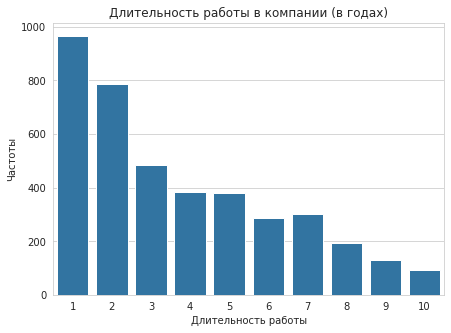

In [34]:
# строим график для признака 'employment_years' на тренировочной выборке
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")
sns.countplot(data=train_sample, x='employment_years')
plt.title('Длительность работы в компании (в годах)')
plt.xlabel('Длительность работы')
plt.ylabel('Частоты')
plt.show()

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> `employment_years` и `supervisor_evaluation` - дискретные признаки, для их анализа нужнен тип графиков, который на каждое уникальные значение признака строит свою корзину. Например, можно использовать `sns.countplot`.
    
Для этих признаков также не нужно строить ящики с усами, так как признак имеет, скорее, распределение категориального признака, пусть и представленного уже в численном виде.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Исправил графики для дискретных признаков. 
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

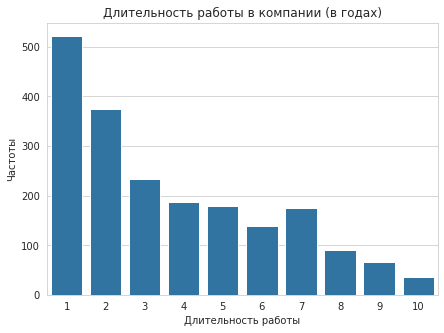

In [35]:
# строим график для признака 'employment_years' на тестовой выборке
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")
sns.countplot(data=test_sample, x='employment_years')
plt.title('Длительность работы в компании (в годах)')
plt.xlabel('Длительность работы')
plt.ylabel('Частоты')
plt.show()

In [36]:
# выводим описательную статистику для признака 'salary' на тренировочной выборке
train_sample['salary'].describe()

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

In [37]:
# выводим описательную статистику для признака 'salary' на тестовой выборке
test_sample['salary'].describe()

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

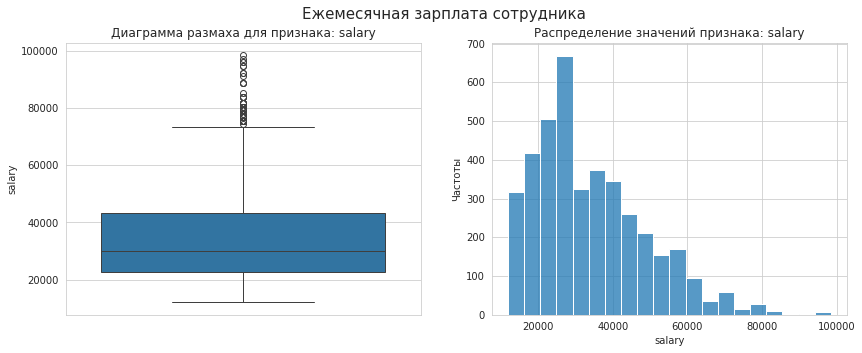

In [38]:
# строим графики для признака 'salary' на тренировочной выборке
quant_feature(dataframe=train_sample, feature='salary', name = 'Ежемесячная зарплата сотрудника')

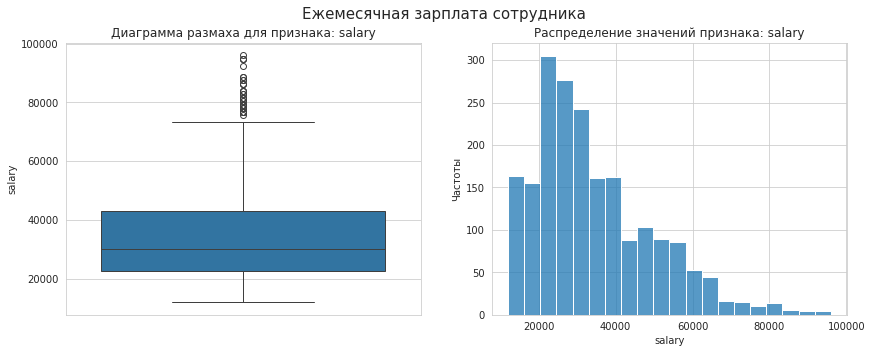

In [39]:
# строим графики для признака 'salary' на тестовой выборке
quant_feature(dataframe=test_sample, feature='salary', name = 'Ежемесячная зарплата сотрудника')

In [40]:
# выводим описательную статистику для признака 'job_satisfaction_rate' на тренировочной выборке
train_sample['job_satisfaction_rate'].describe()

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

In [41]:
# выводим описательную статистику для признака 'job_satisfaction_rate' на тестовой выборке
test_target['job_satisfaction_rate'].describe()

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

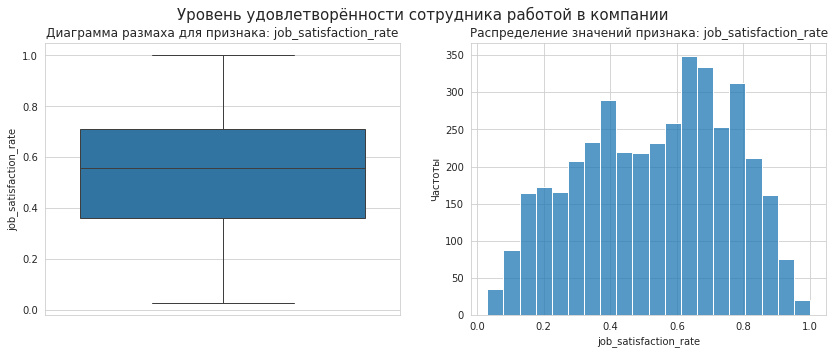

In [42]:
# строим графики для целевого признака 'job_satisfaction_rate' на тренировочной выборке
quant_feature(dataframe=train_sample, feature='job_satisfaction_rate', name = 'Уровень удовлетворённости сотрудника работой в компании')

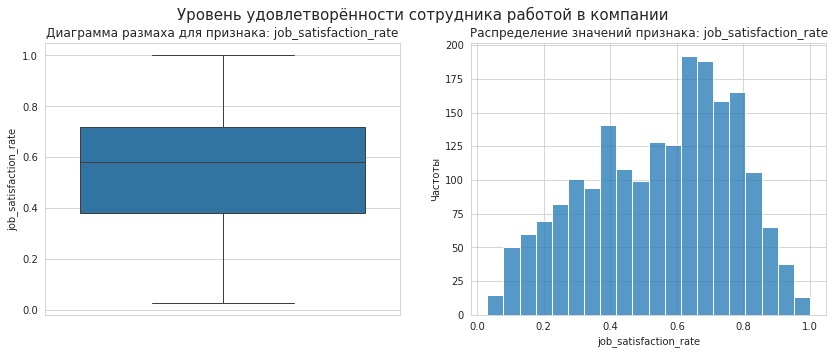

In [43]:
# строим графики для целевого признака 'job_satisfaction_rate' на тестовой выборке
quant_feature(dataframe=test_target, feature='job_satisfaction_rate', name = 'Уровень удовлетворённости сотрудника работой в компании')

In [44]:
# выводим статистику для признака 'supervisor_evaluation' тренировочной выборки
train_sample['supervisor_evaluation'].describe()

count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

In [45]:
# выводим статистику для признака 'supervisor_evaluation' тестовой выборки
test_sample['supervisor_evaluation'].describe()

count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

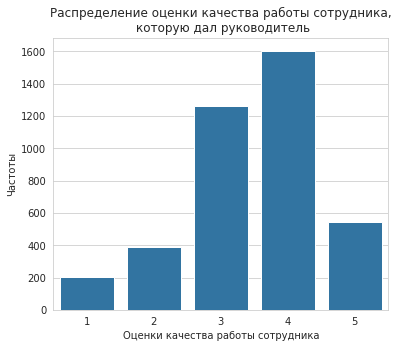

In [46]:
# строим гистрограмму по количественному признаку 'supervisor_evaluation' для тренировочной выборки
plt.figure(figsize=(6, 5))
sns.set_style("whitegrid")
sns.countplot(data=train_sample, x='supervisor_evaluation')
plt.title('Распределение оценки качества работы сотрудника,\n которую дал руководитель')
plt.xlabel('Оценки качества работы сотрудника')
plt.ylabel('Частоты')
plt.show()

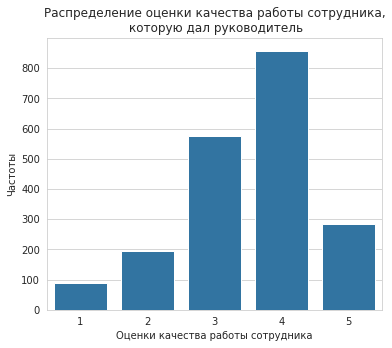

In [47]:
# строим гистрограмму по количественному признаку 'supervisor_evaluation' для тестовой выборки
plt.figure(figsize=(6, 5))
sns.set_style("whitegrid")
sns.countplot(data=test_sample, x='supervisor_evaluation')
plt.title('Распределение оценки качества работы сотрудника,\n которую дал руководитель')
plt.xlabel('Оценки качества работы сотрудника')
plt.ylabel('Частоты')
plt.show()

In [48]:
# выводим статистику для признаков 'dept', 'level', 'workload' на тренировочной выборке
display(train_sample['dept'].value_counts(), train_sample['level'].value_counts(), train_sample['workload'].value_counts())

dept
sales         1518
technology     866
purchasing     610
marketing      550
hr             456
Name: count, dtype: int64

level
junior    1898
middle    1744
senior     358
Name: count, dtype: int64

workload
medium    2066
low       1200
high       734
Name: count, dtype: int64

In [49]:
# выводим статистику для признаков 'dept', 'level', 'workload' на тестовой выборке
display(test_sample['dept'].value_counts(), test_sample['level'].value_counts(), test_sample['workload'].value_counts())

dept
sales         766
technology    455
marketing     279
purchasing    273
hr            227
Name: count, dtype: int64

level
junior    975
middle    854
senior    171
Name: count, dtype: int64

workload
medium    1044
low        593
high       363
Name: count, dtype: int64

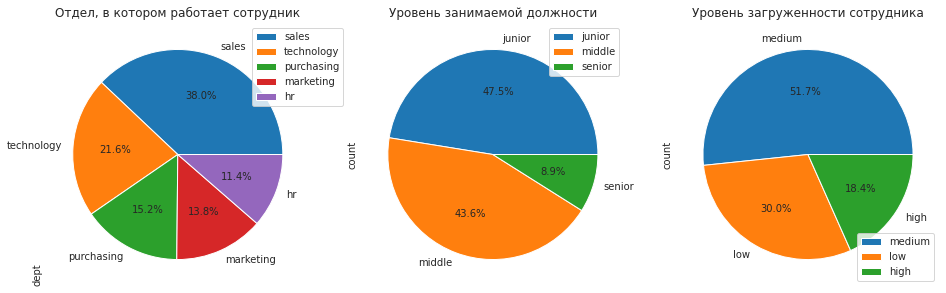

In [50]:
# с помощью subplots выводим круговые диаграммы для 3-х категориальных признаков для тренировочной выборки
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,7))

# построим круговую диаграмму для категориального признака 'покупательская_активность'
train_sample['dept'].value_counts().plot(ax=axes[0], kind = 'pie', legend=True, autopct = '%1.1f%%')
axes[0].set_title('Отдел, в котором работает сотрудник')
axes[0].legend(bbox_to_anchor = (1.15, 1), loc = 'upper right')
axes[0].set_ylabel('dept', loc = 'bottom')

# построим круговую диаграмму для категориального признака 'тип_сервиса'
train_sample['level'].value_counts().plot(ax=axes[1], kind = 'pie', legend=True, autopct = '%1.1f%%')
axes[1].set_title('Уровень занимаемой должности')

# построим круговую диаграмму для категориального признака 'разрешить_сообщать'
train_sample['workload'].value_counts().plot(ax=axes[2], kind = 'pie', legend=True, autopct = '%1.1f%%')
axes[2].set_title('Уровень загруженности сотрудника')
plt.show()

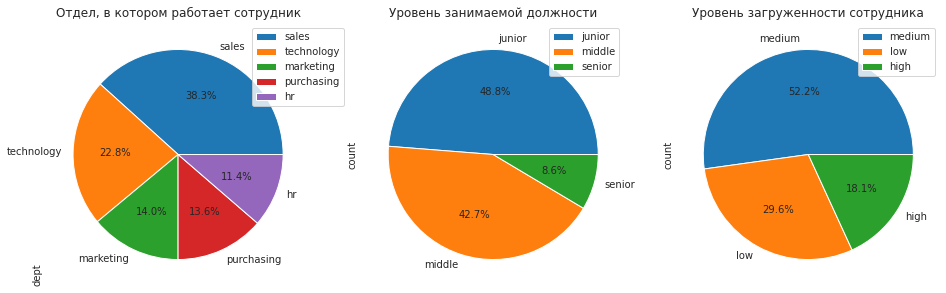

In [51]:
# с помощью subplots выводим круговые диаграммы для 3-х категориальных признаков для тренировочной выборки
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,7))

# построим круговую диаграмму для категориального признака 'покупательская_активность'
test_sample['dept'].value_counts().plot(ax=axes[0], kind = 'pie', legend=True, autopct = '%1.1f%%')
axes[0].set_title('Отдел, в котором работает сотрудник')
axes[0].legend(bbox_to_anchor = (1.15, 1), loc = 'upper right')
axes[0].set_ylabel('dept', loc = 'bottom')

# построим круговую диаграмму для категориального признака 'тип_сервиса'
test_sample['level'].value_counts().plot(ax=axes[1], kind = 'pie', legend=True, autopct = '%1.1f%%')
axes[1].set_title('Уровень занимаемой должности')

# построим круговую диаграмму для категориального признака 'разрешить_сообщать'
test_sample['workload'].value_counts().plot(ax=axes[2], kind = 'pie', legend=True, autopct = '%1.1f%%')
axes[2].set_title('Уровень загруженности сотрудника')
plt.show()

In [52]:
# выводим статистику для признаков 'last_year_promo' и 'last_year_violations' на тренировочной выборке
display(train_sample['last_year_promo'].value_counts(), train_sample['last_year_violations'].value_counts())

last_year_promo
no     3880
yes     120
Name: count, dtype: int64

last_year_violations
no     3441
yes     559
Name: count, dtype: int64

In [53]:
# выводим статистику для признаков 'last_year_promo' и 'last_year_violations' на тестовой выборке
display(test_sample['last_year_promo'].value_counts(), test_sample['last_year_violations'].value_counts())

last_year_promo
no     1937
yes      63
Name: count, dtype: int64

last_year_violations
no     1738
yes     262
Name: count, dtype: int64

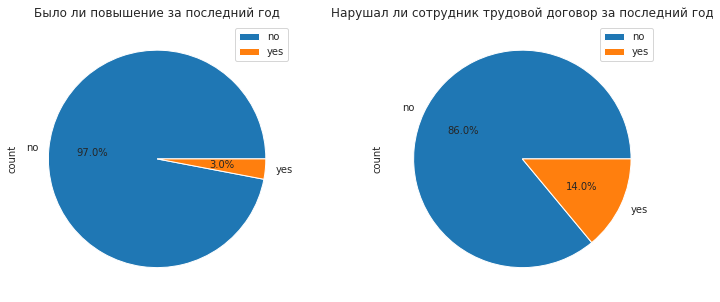

In [54]:
# с помощью subplots выводим круговые диаграммы для 2-х категориальных признаков для тренировочной выборки
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

# построим круговую диаграмму для категориального признака 'покупательская_активность'
train_sample['last_year_promo'].value_counts().plot(ax=axes[0], kind = 'pie', legend=True, autopct = '%1.1f%%')
axes[0].set_title('Было ли повышение за последний год')

# построим круговую диаграмму для категориального признака 'тип_сервиса'
train_sample['last_year_violations'].value_counts().plot(ax=axes[1], kind = 'pie', legend=True, autopct = '%1.1f%%')
axes[1].set_title('Нарушал ли сотрудник трудовой договор за последний год')
plt.show()

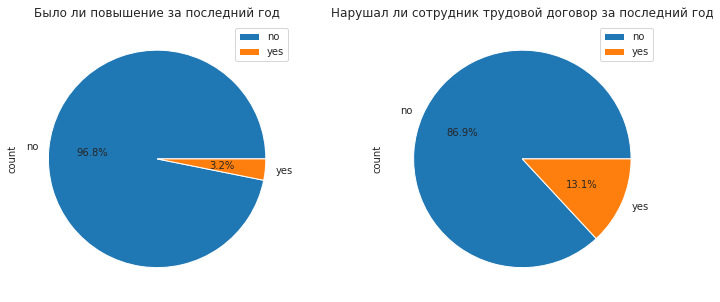

In [55]:
# с помощью subplots выводим круговые диаграммы для 2-х категориальных признаков для тренировочной выборки
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

# построим круговую диаграмму для категориального признака 'покупательская_активность'
test_sample['last_year_promo'].value_counts().plot(ax=axes[0], kind = 'pie', legend=True, autopct = '%1.1f%%')
axes[0].set_title('Было ли повышение за последний год')

# построим круговую диаграмму для категориального признака 'тип_сервиса'
test_sample['last_year_violations'].value_counts().plot(ax=axes[1], kind = 'pie', legend=True, autopct = '%1.1f%%')
axes[1].set_title('Нарушал ли сотрудник трудовой договор за последний год')
plt.show()

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> EDA признаков выполнен.

In [56]:
# задаем непрерывные величины и считаем корреляционную матрицу между всеми признаками датафрейма train_sample
interval_cols = ['salary', 'job_satisfaction_rate']
phik_overview = phik_matrix(train_sample.drop('id', axis=1), interval_cols = interval_cols)

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> `employment_years` и `supervisor_evaluation` - дискретные признаки, их не нужно передавать в `interval_cols`.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Спасибо! Исправил. `supervisor_evaluation` я не включал, а длительность работы как-то подсчитал непрерывным признаком, т.к. стаж по сути непрерывно растёт, но тут у нас кол-во отработанных лет, поэтому выходит, что дискретный признак. 
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

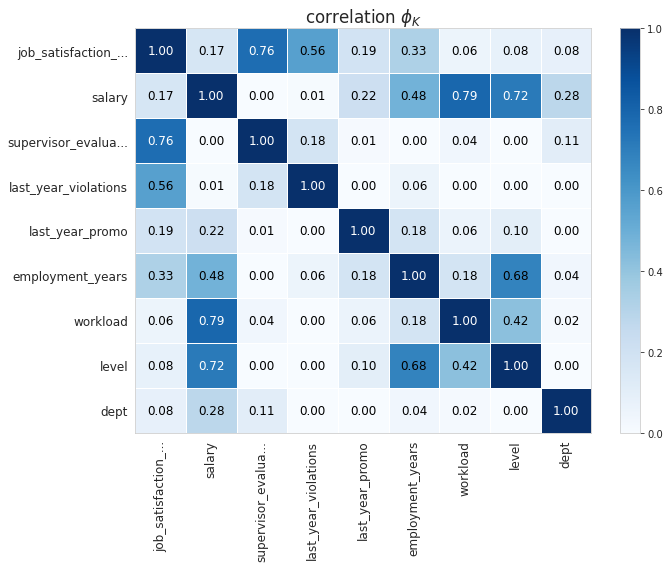

In [57]:
# визуализируем корреляции между всеми признаками датафрейма train_sample
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns,\
                        y_labels=phik_overview.index, vmin=0, vmax=1, color_map='Blues',\
                        title='correlation $\phi_K$', fontsize_factor=1.2, figsize=(10, 8))


In [58]:
# объединим входные и целевой признак тестовой выборки в один датафрейм
test_sample = test_sample.merge(test_target, on='id')
test_sample.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


In [59]:
# считаем корреляционную матрицу между всеми признаками датафрейма test_sample
phik_overview_2 = phik_matrix(test_sample.drop('id', axis=1), interval_cols = interval_cols)

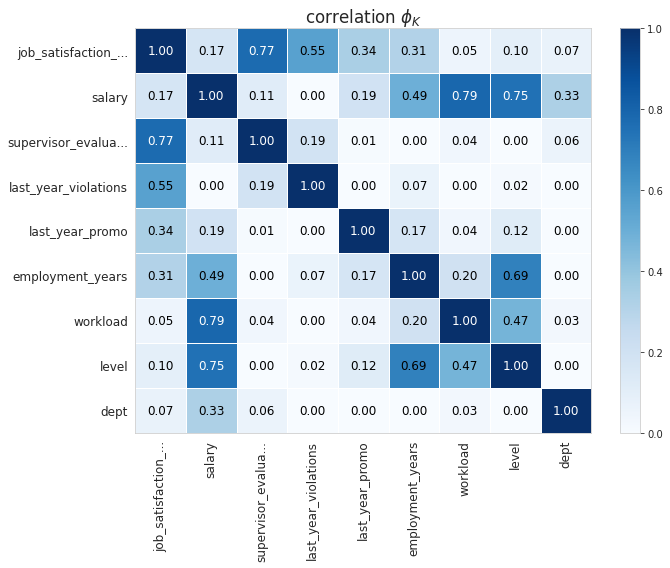

In [60]:
# визуализируем корреляции между всеми признаками датафрейма test_sample
plot_correlation_matrix(phik_overview_2.values, x_labels=phik_overview_2.columns,\
                        y_labels=phik_overview_2.index, vmin=0, vmax=1, color_map='Blues',\
                        title='correlation $\phi_K$', fontsize_factor=1.2, figsize=(10, 8))

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
    
Есть анализ корреляции - молодец, что используешь `phik` для анализа и нелинейных зависимостей, а также настраиваешь `interval_cols` для корректной оценки корреляции для переменных разного типа.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Аналогичный анализ корреляции нужно провести для `test` выборки: так как мы не сами занимались разделением данных на выборки, мы должны убедиться, что в данных нет существенных различий в части распределений признаков и что оценка модели, полученная на `test` выборке, будет корректной.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Добавил корреляционный анализ для тестовой выборки
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

**Выводы:**

Мы изучили описательную статистику и вывели графики для всех признаков отдельно по тренировочной и тестовой выборкам. Для количественных непрерывных признаков мы вывели диаграммы размаха и гистограммы частотного распределения, для дискретных количественных признаков - диаграммы типа `countplot`, а для категориальных признаков вывели круговые диаграммы. Мы убедились, что тренировочная и тестовая выборки не имеют заметных расхождений в распределении значений целевого и входных признаков.

Длительность работы сотрудников в компании варьирует от 1 года до 10 лет. Медианнное значение срока работы в компании - 3 года. Медианное значение ежемесячной зарплаты по тренировочной и тестовой выборкам составляет 30000, а 75% зарплат находится в пределах 43200. График распределения зарплат отличается от нормального. Диаграмма размаха показывает незначительное наличие выбросов, т.е. значений, которые несколько выбиваются из общего тренда зарплат - выше 73000 (выше верхнего уса на диаграмме размаха). Эти значения не являются аномальными, а лишь говорят о наличии незначительного кол-ва сотрудников с более высокими зарплатами, чем у подавляющей части сотрудников. Медианное значение уровня удовлетворённости сотрудника работой в компании - 0.56 по тренировочной выборке и 0.58 по тестовой выборке. Гистограммы показывают распределение отличное от нормального, заметно смещение значений в сторону более 0.5. Диаграмма размаха показывает, что выбросов по признаку нет. Медианное значение оценки качества работы сотрудника, которую дал руководитель, составляет 4. Оценка 4 является также наиболее распространенной оценкой, она составляет не менее 40% по тренировочной и тестовой выборкам.

Больше всего сотрудников работает в отделе продаж (sales) - 38%, а меньше всего сотрудников в отделе управления персоналом (hr) - чуть более 11%. Примерно 48% сотрудников, т.е. большинство,  занимают должность уровня junior, 43% - должность уровня middle, 9% - должность уровня senior. Большая часть сотрудников имеют среднюю загруженность - примерно 52%, тогда как 30% имеют низкую загруженность и 18% высокую загруженность. Всего у 3% сотрудников компании было повышение за последний год, тогда как остальные не получили повышения. Трудовой договор за последний год нарушили примерно 14 % сотрудников.

Мы вывели матрицу корреляции между всеми признаками (за исключением признака id) со значениями коэффициентов корреляции Фи(Phi) отдельно по тернировочной и тествой выборки. Для тестовой выборки мы предварительно объединили датафрейм с входными признаками с целевым признаком. Мы видим, что целевой признак `job_satisfaction_rate` (уровень удовлетворенности сотрудника работой) имеет высокую корреляцию с признаком `supervisor_evaluation` (оценка качества работы сотрудника) - коэффициент корреляции 0.76 по тренировочной и 0.77 по тестовой выборке, а также заметную корреляцию с признаком `last_year_violations` (нарушение трудового договора за последний год) - коэффициент корреляции 0.56 по тренировочной и 0.55 по тестовой выборке. Мультиколлениарности между входными признаками не наблюдается, наиболее высокая корреляция между признаками `salary` (зарплата) и `workload` (загруженность) - значение коэффициента корреляции 0.79 по тернировочной и тестовой выборкам.

### Подготовка данных 

In [61]:
# проверим наличие явных дубликатов в данных тренировочной выборки, используемых для моделирования
train_sample.drop('id', axis=1).duplicated().sum()

np.int64(248)

In [62]:
# видим, что после удаления 'id' в выборке есть дубликаты, удалояем их, т.к. дубли не имеют ценности для модели
train_sample_mod = train_sample.drop('id', axis=1).drop_duplicates().reset_index(drop=True)

In [63]:
# задаем входные и целевые признаки для тренировочной и тестовой выборок
X_train = train_sample_mod.drop(['job_satisfaction_rate'], axis=1)

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> После удаления `id` (но до удаления `job_satisfaction_rate`) нужно проверить наличие новых дубликатов в данных: так как мы удалили часть лишних признаков, у нас могут появиться новые явные дубликаты: чем меньше признаков остаётся, тем выше шанс, что значения остальных признаков будут пересекаться. При этом ценности для модели такие наблюдения уже не принесут, поэтому стоит проверить дубликаты также в финальной версии таблицы.
    
При этом важно проверить только `train`: наличие дубликатов в `test` нам никак не мешает, но это правильное решение с точки зрения неприкосновенности `test`, ведь реальный поток данных (который имитирует `test` выборка) мы исправить не сможем. А вот наличие дубликатов в `train` не только не принесёт пользы модели, но может и навредить.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Спасибо за замечание, запомню этот момент. Исправил.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

In [64]:
y_train = train_sample_mod['job_satisfaction_rate']
X_test = test_sample.drop(['job_satisfaction_rate', 'id'], axis=1)
y_test = test_sample['job_satisfaction_rate']

In [65]:
# задаем категориальные признаки для разных типов кодтирования и количественные признаки 
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [66]:
# создаем пайплайн для кодирования признаков методом OneHotEncoder
ohe_pipe = Pipeline(
    [
        (
          'simple_imputer_ohe',
          SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
          'ohe',
          OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

# создаем пайплайн для кодирования признаков методом OrdinalEncoder
ord_pipe = Pipeline(
    [
        (
            'simple_imputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
               categories = [
                   ['junior', 'middle', 'senior'],
                   ['low', 'medium', 'high']
               ],
               handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simple_imputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# создаем пайплайн для масштабирования признаков с помощью StandardScaler
num_pipe = Pipeline(
    [
        (
            'simple_imputer_before_num',
            SimpleImputer(missing_values=np.nan, strategy='median')
        ),
        (
            'scaler', StandardScaler() 
        ) 
    ]
)

In [67]:
# создаем пайплайн для обработки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

In [68]:
# выведем датафреймы с преобразованными входными признаками после кодирования и масштабирования
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=data_preprocessor.get_feature_names_out()
)

X_test_p = pd.DataFrame(
   data_preprocessor.transform(X_test),
   columns=data_preprocessor.get_feature_names_out()
)

display(X_train_p.head())
X_test_p.head()

,ohe__dept_marketing,ohe__dept_purchasing,ohe__dept_sales,ohe__dept_technology,ohe__last_year_promo_yes,ohe__last_year_violations_yes,ord__level,ord__workload,num__employment_years,num__supervisor_evaluation,num__salary
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.711613,-2.400409,-0.695081
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.711613,1.497593,0.261524
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.102760,-1.425908,-1.492251
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.070682,-1.425908,-1.093666
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.102760,-0.451408,-0.774798


,ohe__dept_marketing,ohe__dept_purchasing,ohe__dept_sales,ohe__dept_technology,ohe__last_year_promo_yes,ohe__last_year_violations_yes,ord__level,ord__workload,num__employment_years,num__supervisor_evaluation,num__salary
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.711613,1.497593,-0.376213
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.102760,0.523093,-0.296495
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.461829,0.523093,-1.013949
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.852976,0.523093,-1.013949
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.461829,1.497593,0.420958


**Выводы:**

После удаления из признаков, используемых в моделировании, признака 'id' мы провели проверку на наличие явных дубликатов по оставшимся данным в тренировочной выборке. Мы обнаружили 248 дублей и удалили их, т.к. они не представляют ценности для моделирования. Из входных признаков, которые мы будем использовать для моделирования мы исключили признак 'id'. Затем мы выделили категориальные признаки для кодирования методом OneHotEncoder и кодирования методом OrdinalEncoder, а также количественные признаки для масштабирования или нормализации. С помощью OrdinalEncoder мы решили кодировать признаки, которые можно поместить на шкалу в порядке возрастания, т.е. ранжировать - `'level'` и `'workload'`. Для признака `'level'` можно ранжировать значения по возрастанию уровня должности: 'junior', 'middle', 'senior'. Для признака `'workload'` можно ранжировать значения в порядке возрастания уровня загруженности: 'low', 'medium', 'high'. Затем мы создали отдельные пайплайны для кодирования с помощью OneHotEncoder, кодирования с помощью OrdinalEncoder, масштабирования с помощью StandardScaler. В каждый из указанных пайплайнов для обработки данных мы добавили обработку пропусков с помощью класса SimpleImputer. В кодировщик OrdinalEncoder мы добавили упорядоченные списки категорий для признаков `'level'` и `'workload'`. 

На следующем этапе мы создали пайплайн для обработки данных и преобразования столбцов с помощью ColumnTransform. Мы включили в этот пайплайн три созданных ранее пайплайна для кодирования и масштабирования данных. Затем чтобы посмотреть выполнение этапа подготовки данных, мы сформировали датафреймы из преобразованных данных для тренировочной и тестовой выборок и вывели первые строки датафреймов на экран.

### Обучение моделей 

In [69]:
# с помощью функции создаем метрику для оценки качества моделей - SMAPE (симметричное среднее абсолютное процентное отклонение) 
def smape(y_true, y_pred):
    metric =  100*np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred))/2))
    return metric

smape_scorе = make_scorer(smape, greater_is_better=False)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Есть функция для оценки `sMAPE`, а также пользовательский скорринг для кросс-валидации - супер!
</div>

In [70]:
# создаём итоговый пайплайн с подготовкой данных и моделью
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

In [71]:
# задаем словари гиперпараметров для двух линейных моделей  
param_rs = [
    # для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
     # для модели SVR()
    {
        'models': [SVR(kernel='rbf')],
        'models__C': range(1, 5),
        'models__gamma': [0.1, 0.2, 0.3, 0.5, 1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
     # для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__min_samples_split': range(2, 5),
        'models__min_samples_leaf': range(1, 4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }   
             ]

In [72]:
# находим лучшую модель на данных кросс-валидационной выборки
rs = RandomizedSearchCV(pipe_final, param_distributions=param_rs, cv=5, scoring=smape_scorе,
                        n_iter=20, n_jobs=-1, verbose=3, random_state=RANDOM_STATE)
rs.fit(X_train, y_train)
# выводим параметры лучшей модели
print('Лучшая модель и её параметры:\n\n', rs.best_estimator_,'\n\n', rs.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END models=LinearRegression(), preprocessor__num=StandardScaler();, score=-25.206 total time=   0.0s
[CV 2/5] END models=LinearRegression(), preprocessor__num=StandardScaler();, score=-24.858 total time=   0.1s
[CV 3/5] END models=LinearRegression(), preprocessor__num=StandardScaler();, score=-26.061 total time=   0.2s
[CV 4/5] END models=LinearRegression(), preprocessor__num=StandardScaler();, score=-25.112 total time=   0.1s
[CV 5/5] END models=LinearRegression(), preprocessor__num=StandardScaler();, score=-23.718 total time=   0.1s
[CV 1/5] END models=SVR(), models__C=1, models__gamma=0.2, preprocessor__num=MinMaxScaler();, score=-21.868 total time=   0.4s
[CV 2/5] END models=SVR(), models__C=1, models__gamma=0.2, preprocessor__num=MinMaxScaler();, score=-20.827 total time=   0.3s
[CV 3/5] END models=SVR(), models__C=1, models__gamma=0.2, preprocessor__num=MinMaxScaler();, score=-21.342 total time=   0.3s
[CV 4/5

In [73]:
# считаем и выводим для лучшей модели метрику smape
print('Значение метрики SMAPE для лучшей модели:', abs(round(rs.best_score_, 3)))

Значение метрики SMAPE для лучшей модели: 14.755


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Найдена лучшая модель.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

Как видишь, твоя метрика имеет отрицательное значение - это особеность работы `make_scorer` с настроенным параметром `greater_is_better=False`: так как метрика `sMAPE` применяется для задач регрессии, то она тем лучше, чем ниже - это нужно учитывать при создании скорринга для кросс-валидации, так как по умолчанию инструменты подбора гиперпараметров и поиска лучшей модели вроде `GridSearchCV` умеют только максимизировать метрику качества. Поэтому при создании скорринга с помощью `make_scorer` важно настроить параметр `greater_is_better=False`, чтобы оптимизируемая метрика минимизировалась, а не максимизировалась - таким образом задача максимизации будет решаться через задачу минимизации обратной функции.
    
Поэтому при выводе метрики на экран её стоит сделать положительной: взять по модулю, домножить на `-1` или просто указать `-` при выводе на экран, вроде `print(-a)`.
        
</div>

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Спасибо за разъяснение, Алексей! До конца не понимал, почему получается отрицательное значение по поиску, при том что при проверке на тестовой выборке по заданной формуле у метрики положительное значение. Теперь понял. Исправил.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

In [74]:
# по лучшей модели делаем прогноз на тестовой выборке
y_pred = rs.predict(X_test)
# считаем и выводим для лучшей модели метрику smape на тестовой выборке
smape_test = smape(y_test, y_pred)
print('Значение метрики SMAPE для лучшей модели на тестовой выборке:', round(smape_test, 3))

Значение метрики SMAPE для лучшей модели на тестовой выборке: 13.435


In [75]:
# проверим лучшую модель на адекватность, сравнив качество её предсказаний с качеством предсказаний модели DummyRegressor(strategy="median")
dummy_model = DummyRegressor(strategy="median")
dummy_model.fit(X_train, y_train)
y_pred_dummy = dummy_model.predict(X_test)
smape_test_dummy = smape(y_test, y_pred_dummy)
print('Значение метрики SMAPE для модели DummyRegressor на тестовой выборке:', round(smape_test_dummy, 3))

Значение метрики SMAPE для модели DummyRegressor на тестовой выборке: 37.773


Мы видим, что у лучшей модели значение метрики SMAPE на тестовой выборке заметно лучше, чем у модели DummyRegressor. Значит лучшая модель адекватная.

<div class="alert alert-success">
    
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Лучшую модель оценили на `test` - отличный результат!

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b>
Очень важно также проверить лучшую модель на адекватность, сравнив качество её предсказаний с качеством модели, которая предсказывала бы константу - вдруг окажется, что не было бы большого смысла заниматься созданием новых признаков, тюнингом и кросс-валидацией моделей, если можно было бы просто предсказывать среднее значение тренировочной выборки? 
    
В качестве константной модели можно использовать `DummyRegressor` (https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) -  эта модель как раз создана для генерирования константных предсказаний.
    
Важно, чтобы результат тестирования нашей модели на тествой выборке был лучше, чем результат константной модели - в противном случае наша модель является бесполезной, так как все наши усилия над проектом не принесли результата, а можель, просто предсказывющая среднее на `train`, делает нашу работу лучше.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Спасибо за информацию. Проверил модель на адекватной, сравнив качество её предсказаний с качеством предсказаний DummyRegressor.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

### Оформление выводов

Мы создали итоговый пайплайн для решения задачи, в который включили пайплайн подготовки данных и обработку моделью. Затем мы задали словари с гиперпараметрами для трёх моделей. Мы выбрали в качестве линейных две регрессионные модели LinearRegression() и SVR(). А в качестве третьей модели мы взяли дерево решений DecisionTreeRegressor(). Для моделей SVR() и  DecisionTreeRegressor() мы задали гиперпараметры. Кроме того, для всех моделей мы установили подбор оптимального метода масштабирования количественных признаков - StandardScaler() и MinMaxScaler(). Для модели DecisionTreeRegressor() мы задали подбор оптимальных значений по диапазону для параметров "минимальное число объектов в узле" и "минимальное число объектов в листе". Для модели SVR мы определили тип оптимального ядра в алгоритме модели как 'rbf' и задали подбор значений для коэффициентов силы регуляризации C и gamma. В заключении мы запустили оптимизацию гиперпараметров с помощью селектора RandomizedSearchCV, в который включили заданный словарь гиперпараметров. Мы зафиксировали тип кросс-валидации (задали значение 5), значение random_state и метрику для оценки качества обученных моделей - SMAPE («симметричное среднее абсолютное процентное отклонение»), расчёт которой по параметрам задали с помощью специальной функции. Таким образом, мы использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров.

Результаты подбора лучшей модели по параметрам показали, что хуже всего справляется с прогнозом целевого признака модель LinearRegression(). По сравнению с LinearRegression() модель DecisionTreeRegressor(random_state=42) при определенных значениях минимального числа объектов в листе/ в узле даёт гораздо лучшие значения метрики SMAPE на кросс-валидационной выборке. И всё-таки в качестве лучшей модели для прогноза целевого признака была выбрана модель SVR() c коэффициентами регуляризации C=4 и gamma=0.3, оптимальным ядром 'rbf' и масштабированием количественных признаков с помощью StandardScaler(). Значение метрики SMAPE для лучшей модели 14.755, а значение SMAPE для лучшей модели на тестовой выборке 13.435. Таким образом, SMAPE ≤ 15, что можно считать критерием успеха.

Результаты говорят о том, что сложные линейные модели достаточно хорошо справляются с поставленной задачей прогноза, превосходят "дерево решений" (DecisionTreeRegressor()). Модель LinearRegression() работает плохо, поскольку хорошо может работать только при линейных зависимостях между признаками. Очевидно, в нашей задаче зависимость между целевым и входными признаками нелинейная. Модель DecisionTreeRegressor() устойчива к выбросам, может фиксировать нелинейные связи между входными и целевым признаками и может представлять сложные границы решений, что однако оказалось поставленной задачи. Кроме того, модель DecisionTreeRegressor(). Модель SVR показала лучший результат, поскольку способна улавливать сложные нелинейные зависимости между признаками благодаря настройке ядра, устойчива к переобучению (в отличие от модели типа  "дерево решений") благодаря использованию коэффициентов силы регуляризации, устойчива к выбросам и в целом обладает лучшими обобщающими способностями по сравнению с DecisionTreeRegressor(). В целом модель SVR() даёт высокую точность прогнозов и эффективно работает с относительно небольшим кол-вом данных.

Мы проверили получившуюся лучшую модель на адекватность, сравнив качество её предсказаний с качеством предсказаний модели DummyRegressor с настройкой вывода медианных значений в качестве предсказаний. Мы видим, что у лучшей модели значение метрики SMAPE на тестовой выборке заметно лучше, чем у модели DummyRegressor. Значит наша лучшая модель адекватная.

<div class="alert alert-success">
    
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Молодец, что не забываешь про промежуточные выводы.

## Задача 2: предсказание увольнения сотрудника из компании 

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Для этой задачи аналогичны все замечания из предыдущей в части аналогичных активностей. 
        
Ниже будут отмечены только новые замечания.

### Загрузка данных 

In [76]:
# загружаем данные для первой задачи и сохраняем в датафреймы
try:
    train_quit_sample = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
    test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
    test_quit_target = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')
except:
    train_quit_sample = pd.read_csv('train_quit.csv')
    test_features =  pd.read_csv('test_features.csv')
    test_quit_target = pd.read('test_target_quit.csv')

In [77]:
# выводим общую информацию и первые строки для тренировочной выборки
display(train_quit_sample.head())
train_quit_sample.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [78]:
# выводим общую информацию и первые строки датафрейма тестовой выборки с входными признаками
display(test_features.head())
test_features.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [79]:
# выводим общую информацию и первые строки датафрейма тестовой выборки с целевым признаком
display(test_quit_target.head())
test_quit_target.info()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


**Выводы:**

Мы загрузили данные для второй задачи и сохранили их в 3 датафрейма: с данными тренировочной выборки, данными тестовой выборки с входными признаками и данные тестовой выборки с целевым признаком. Мы вывели на экран первые строки и общую информацию по датафреймам. В датафрейме с входными признаками тестовой выборки есть небольшое число пропусков в столбцах `dept` и `level`. Тип данных по всем столбцам задан верно. Также названия столбцов приведены к змеиному регистру.

### Преодбработка данных 

In [80]:
# создаем пайплайн для обработки пропусков и с помощь него преобразуем пропуски, сохраняем перобразованные датафреймы
s_imputer.fit(test_features[imputer_col])
test_features[s_imputer.feature_names_in_] = s_imputer.transform(test_features[imputer_col])

In [81]:
# проверяем заполненность пропусков
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   2000 non-null   object
 2   level                  2000 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [82]:
# проверяем наличие полных дублей
train_quit_sample.duplicated().sum()

np.int64(0)

In [83]:
# проверяем наличие полных дублей
test_features.duplicated().sum()

np.int64(0)

In [84]:
# проверяем наличие полных дублей
test_quit_target.duplicated().sum()

np.int64(0)

In [85]:
# ищем возможные неявные дубликаты в категориальных признаках тренировочной выборки
train_quit_sample['dept'].unique()

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

In [86]:
# ищем возможные неявные дубликаты в категориальных признаках тренировочной выборки
train_quit_sample['level'].unique()

array(['middle', 'junior', 'sinior'], dtype=object)

In [87]:
# исправляем написание значения признака
train_quit_sample['level'] = train_quit_sample['level'].replace({'sinior': 'senior'})

In [88]:
# ищем возможные неявные дубликаты в категориальных признаках тренировочной выборки
train_quit_sample['workload'].unique()

array(['high', 'medium', 'low'], dtype=object)

In [89]:
# ищем возможные неявные дубликаты в категориальных признаках тренировочной выборки
train_quit_sample['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [90]:
# ищем возможные неявные дубликаты в категориальных признаках тренировочной выборки
train_quit_sample['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [91]:
# ищем возможные неявные дубликаты в категориальных признаках тестовой выборки
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology'],
      dtype=object)

In [92]:
# ищем возможные неявные дубликаты в категориальных признаках тестовой выборки
test_features['level'].unique()

array(['junior', 'middle', 'sinior'], dtype=object)

In [93]:
# исправляем написание значения признака
test_features['level'] = test_features['level'].replace({'sinior': 'senior'})

In [94]:
# ищем возможные неявные дубликаты в категориальных признаках тестовой выборки
test_features['workload'].unique()

array(['medium', 'low', 'high'], dtype=object)

In [95]:
# ищем возможные неявные дубликаты в категориальных признаках тестовой выборки
test_features['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [96]:
# ищем возможные неявные дубликаты в категориальных признаках тестовой выборки
test_features['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

**Выводы:**

Мы обработали пропуски в категориальных данных с помощью пайплайна, который создали ранее при решении первой задачи. В пайплайне мы иcпользовали для выявления и заполнения пропусков класс `SimpleImputer`. Пропущенные значения мы меняли на наиболее часто встречающиеся значения в столбце (`most_frequent`). В результате применения пайплайна мы получили новые заполненные значения категориальных признаков, затем заменили старые значения на полученные новые и сохранили в датафрейме тестовой выборок. Так мы получили датафрейм без пропусков. Затем мы провели проверку датафреймов на наличие явных и неявных дубликатов. Дублей не обнаружено.

### Исследовательский анализ данных 

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Перед началом анализа портрета уходящего работника, нужно выполнить базовый EDA новой `train` выборки по аналогии с первой задачей.
    
Анализ портрета уходящего работника нужно выполнить по `train` данными (если в условии проекта не указано обратное, всегда используем `train` для ответа на вопросы заказчика, так как в этой выборке содержатся паттерны, которые изучает модель в ходе обучения).

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Понял насчёт анализа портерта, исправил. Добавил базовый EDA для новой train выборки. Сразу не добавил, решив что данные несильно расходятся с тренировочной выборкой для первой задачи.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

In [97]:
# выводим описательную статистику для признака 'employment_years' на тренировочной выборке
train_quit_sample['employment_years'].describe()

count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

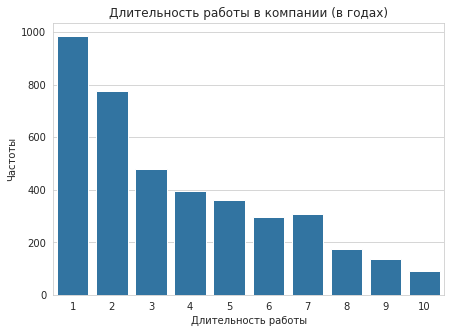

In [98]:
# строим график для признака 'employment_years' на тренировочной выборке
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")
sns.countplot(data=train_quit_sample, x='employment_years')
plt.title('Длительность работы в компании (в годах)')
plt.xlabel('Длительность работы')
plt.ylabel('Частоты')
plt.show()

In [99]:
# выводим описательную статистику для признака 'salary' на тренировочной выборке
train_quit_sample['salary'].describe()

count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

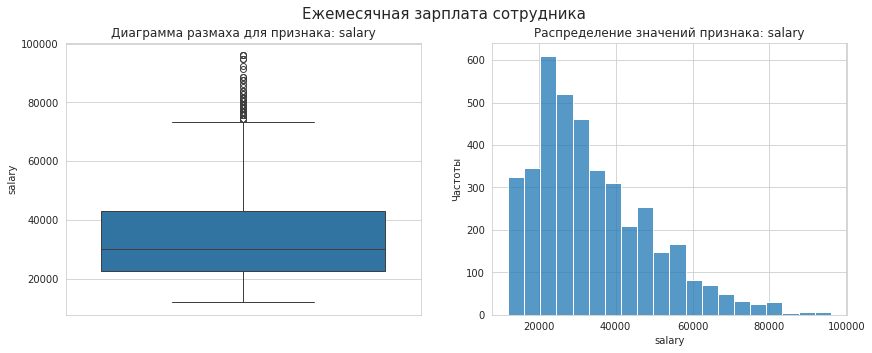

In [100]:
# строим графики для признака 'salary' на тренировочной выборке
quant_feature(dataframe=train_quit_sample, feature='salary', name = 'Ежемесячная зарплата сотрудника')

In [101]:
# выводим статистику для признака 'supervisor_evaluation' тренировочной выборки
train_quit_sample['supervisor_evaluation'].describe()

count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

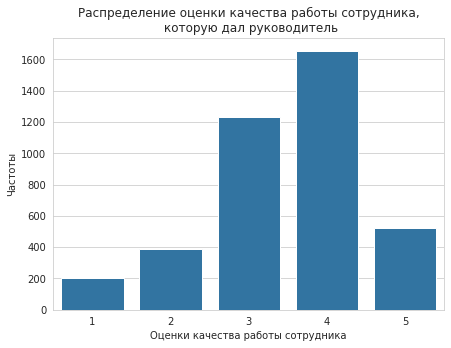

In [102]:
# строим гистрограмму по количественному признаку 'supervisor_evaluation' для тренировочной выборки
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")
sns.countplot(data=train_quit_sample, x='supervisor_evaluation')
plt.title('Распределение оценки качества работы сотрудника,\n которую дал руководитель')
plt.xlabel('Оценки качества работы сотрудника')
plt.ylabel('Частоты')
plt.show()

In [103]:
# выводим статистику для признаков 'dept', 'level', 'workload' на тренировочной выборке
display(train_quit_sample['dept'].value_counts(), train_quit_sample['level'].value_counts(),
        train_quit_sample['workload'].value_counts())

dept
sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: count, dtype: int64

level
junior    1949
middle    1694
senior     357
Name: count, dtype: int64

workload
medium    2118
low       1208
high       674
Name: count, dtype: int64

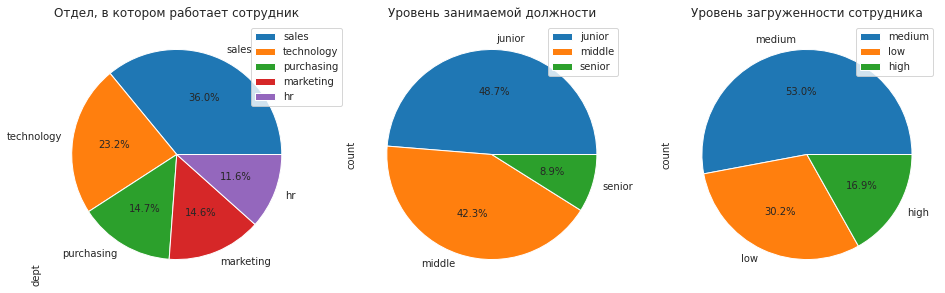

In [104]:
# с помощью subplots выводим круговые диаграммы для 3-х категориальных признаков для тренировочной выборки
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,7))

# построим круговую диаграмму для категориального признака 'покупательская_активность'
train_quit_sample['dept'].value_counts().plot(ax=axes[0], kind = 'pie', legend=True, autopct = '%1.1f%%')
axes[0].set_title('Отдел, в котором работает сотрудник')
axes[0].legend(bbox_to_anchor = (1.15, 1), loc = 'upper right')
axes[0].set_ylabel('dept', loc = 'bottom')

# построим круговую диаграмму для категориального признака 'тип_сервиса'
train_quit_sample['level'].value_counts().plot(ax=axes[1], kind = 'pie', legend=True, autopct = '%1.1f%%')
axes[1].set_title('Уровень занимаемой должности')

# построим круговую диаграмму для категориального признака 'разрешить_сообщать'
train_quit_sample['workload'].value_counts().plot(ax=axes[2], kind = 'pie', legend=True, autopct = '%1.1f%%')
axes[2].set_title('Уровень загруженности сотрудника')
plt.show()

In [105]:
# выводим статистику для признаков 'last_year_promo' и 'last_year_violations' на тренировочной выборке
display(train_sample['last_year_promo'].value_counts(), train_sample['last_year_violations'].value_counts())

last_year_promo
no     3880
yes     120
Name: count, dtype: int64

last_year_violations
no     3441
yes     559
Name: count, dtype: int64

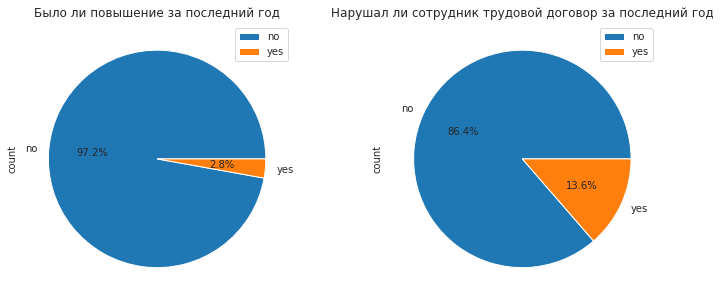

In [106]:
# с помощью subplots выводим круговые диаграммы для 2-х категориальных признаков для тренировочной выборки
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

# построим круговую диаграмму для категориального признака 'покупательская_активность'
train_quit_sample['last_year_promo'].value_counts().plot(ax=axes[0], kind = 'pie', legend=True, autopct = '%1.1f%%')
axes[0].set_title('Было ли повышение за последний год')

# построим круговую диаграмму для категориального признака 'тип_сервиса'
train_quit_sample['last_year_violations'].value_counts().plot(ax=axes[1], kind = 'pie', legend=True, autopct = '%1.1f%%')
axes[1].set_title('Нарушал ли сотрудник трудовой договор за последний год')
plt.show()

In [107]:
# выводим относительное распределение значений целевого признака по тренировочной выборке
train_quit_sample['quit'].value_counts(normalize=True)

quit
no     0.718
yes    0.282
Name: proportion, dtype: float64

In [108]:
# выводим относительное распределение значений целевого признака по тестовой выборке
test_quit_target['quit'].value_counts(normalize=True)

quit
no     0.718
yes    0.282
Name: proportion, dtype: float64

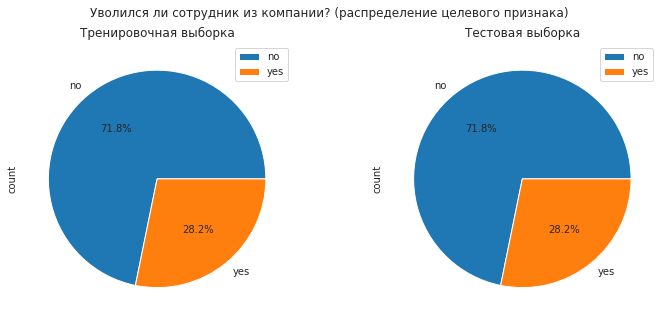

In [109]:
# с помощью subplots выводим круговые диаграммы для целевого признака 'quit' по тренировочной и тестовой выборкам
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
fig.suptitle('Уволился ли сотрудник из компании? (распределение целевого признака)', fontsize=12)

# по тренировочной выборке
train_quit_sample['quit'].value_counts().plot(ax=axes[0], kind = 'pie', legend=True, autopct = '%1.1f%%')
axes[0].set_title('Тренировочная выборка')

# по тестовой выборке
test_quit_target['quit'].value_counts().plot(ax=axes[1], kind = 'pie', legend=True, autopct = '%1.1f%%')
axes[1].set_title('Тестовая выборка')
plt.show()

In [110]:
# объединим входные и целевой признак тестовой выборки в один датафрейм
test_features = test_features.merge(test_quit_target, on='id')
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,no
1,686555,hr,junior,medium,1,no,no,4,30000,no
2,467458,sales,middle,low,5,no,no,4,19200,no
3,418655,sales,middle,low,6,no,no,4,19200,no
4,789145,hr,middle,medium,5,no,no,5,40800,no


In [111]:
# относительные частоты значений признака 'employment_years' для уволившихся сотрудников
train_quit_sample.query('quit=="yes"')['employment_years'].value_counts(normalize=True)

employment_years
1     0.531028
2     0.257092
3     0.144504
4     0.023936
5     0.020390
6     0.008865
7     0.006206
10    0.002660
8     0.002660
9     0.002660
Name: proportion, dtype: float64

In [112]:
# оотносительные частоты значений признака 'employment_years' для неуволившихся сотрудников
train_quit_sample.query('quit=="no"')['employment_years'].value_counts(normalize=True)

employment_years
2     0.169568
1     0.134401
4     0.127437
5     0.118036
3     0.110028
7     0.104805
6     0.099582
8     0.059540
9     0.046309
10    0.030292
Name: proportion, dtype: float64

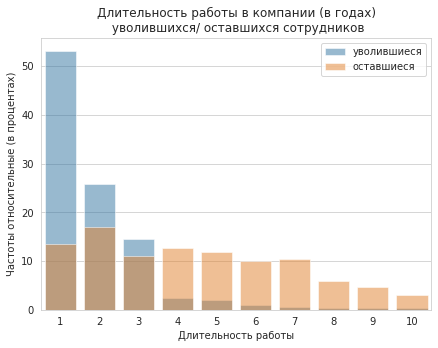

In [113]:
# строим графики для признака 'employment_years' в разрезе по 'quit'
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")
ax=sns.countplot(data=train_quit_sample.query('quit=="yes"'), x='employment_years', stat='percent',
                alpha=0.5)
sns.countplot(data=train_quit_sample.query('quit=="no"'), x='employment_years', stat='percent',
              alpha=0.5, ax=ax)
plt.ylabel('Частоты относительные (в процентах)')
plt.xlabel('Длительность работы')
plt.title('Длительность работы в компании (в годах)\n уволившихся/ оставшихся сотрудников')
plt.legend(['уволившиеся', 'оставшиеся'])
plt.show()

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> См.ранее по анализу дискретных признаков. Для выполнения анализа в разрезе оттока можно использовать параметр `hue`.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Исправил.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

In [114]:
# медианное значение по признаку 'salary' для уволившихся сотрудников
train_quit_sample.query('quit=="yes"')['salary'].median()

np.float64(22800.0)

In [115]:
# медианное значение по признаку 'salary' для неуволившихся сотрудников
train_quit_sample.query('quit=="no"')['salary'].median()

np.float64(34800.0)

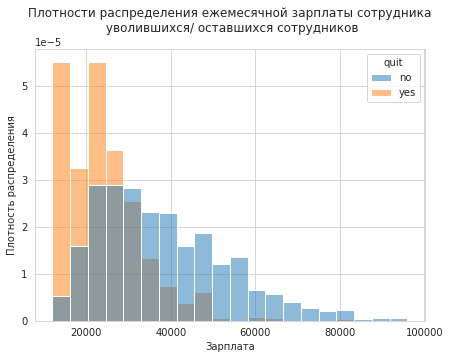

In [116]:
# строим график для признака 'salary'
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")
sns.histplot(stat='density', common_norm=False, data=train_quit_sample, x='salary', hue='quit', bins=20)
plt.ylabel('Плотность распределения')
plt.xlabel('Зарплата')
plt.title('Плотности распределения ежемесячной зарплаты сотрудника\n уволившихся/ оставшихся сотрудников')
plt.show()

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Здесь мы имеем дело с анализом распределения непрерывной величины, а сам анализ проводится по двум выборкам разного размера - для анализа их распределения стоит использовать нормированную гистограмму (например, `shs.histplot()` с параметрами `stat='density', common_norm=False` или `sns.kdeplot()`): гистограммы такого типа позволяют нивелировать разницу в размерах выборок при анализе распределений. Обрати также внимание, что при использовании нормированных гистограмм по оси Y будет уже не частота значений, а плотность распределения.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Исправил! Спасибо, буду знать про нормирование. Думал о том, что, если бы в значениях целевого признака был сильный дисбаланс, то частотные графики выглядели бы совсембы плохо и неинформативно.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

In [117]:
# относительные частоты значений признака 'dept' для уволившихся сотрудников
train_quit_sample.query('quit=="yes"')['dept'].value_counts(normalize=True)

dept
sales         0.360816
technology    0.244681
purchasing    0.147163
marketing     0.144504
hr            0.102837
Name: proportion, dtype: float64

In [118]:
# относительные частоты значений признака 'dept' для неуволившихся сотрудников
train_quit_sample.query('quit=="no"')['dept'].value_counts(normalize=True)

dept
sales         0.358983
technology    0.227019
purchasing    0.146936
marketing     0.145891
hr            0.121170
Name: proportion, dtype: float64

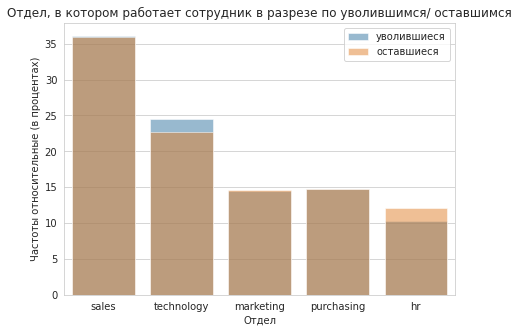

In [119]:
# строим графики для признака 'dept' в разрезе по 'quit'
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")
ax=sns.countplot(data=train_quit_sample.query('quit=="yes"'), x='dept', stat='percent', alpha=0.5)
sns.countplot(data=train_quit_sample.query('quit=="no"'), x='dept', stat='percent', alpha=0.5, ax=ax)
plt.ylabel('Частоты относительные (в процентах)')
plt.xlabel('Отдел')
plt.title('Отдел, в котором работает сотрудник в разрезе по уволившимся/ оставшимся')
plt.legend(['уволившиеся', 'оставшиеся'])
plt.show()

In [120]:
# относительные частоты значений признака 'level' для уволившихся сотрудников
train_quit_sample.query('quit=="yes"')['level'].value_counts(normalize=True)

level
junior    0.889184
middle    0.095745
senior    0.015071
Name: proportion, dtype: float64

In [121]:
# относительные частоты значений признака 'level' для неуволившихся сотрудников
train_quit_sample.query('quit=="no"')['level'].value_counts(normalize=True)

level
middle    0.552228
junior    0.329387
senior    0.118384
Name: proportion, dtype: float64

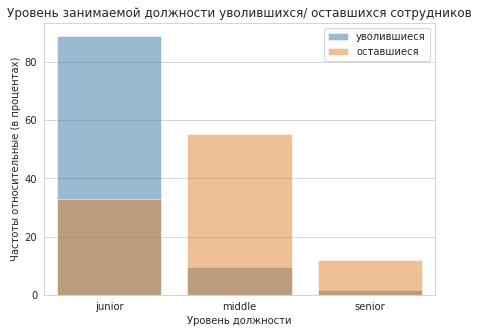

In [122]:
# строим графики для признака 'level' в разрезе по 'quit'
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")
ax=sns.countplot(data=train_quit_sample.query('quit=="yes"'), x='level', stat='percent', alpha=0.5)
sns.countplot(data=train_quit_sample.query('quit=="no"'), x='level', stat='percent',
              alpha=0.5, ax=ax)
plt.ylabel('Частоты относительные (в процентах)')
plt.xlabel('Уровень должности')
plt.title('Уровень занимаемой должности уволившихся/ оставшихся сотрудников')
plt.legend(['уволившиеся', 'оставшиеся'])
plt.show()

In [123]:
# относительные частоты значений признака 'workload' для уволившихся сотрудников
train_quit_sample.query('quit=="yes"')['workload'].value_counts(normalize=True)

workload
low       0.460106
medium    0.432624
high      0.107270
Name: proportion, dtype: float64

In [124]:
# относительные частоты значений признака 'workload' для неуволившихся сотрудников
train_quit_sample.query('quit=="no"')['workload'].value_counts(normalize=True)

workload
medium    0.567549
low       0.239903
high      0.192549
Name: proportion, dtype: float64

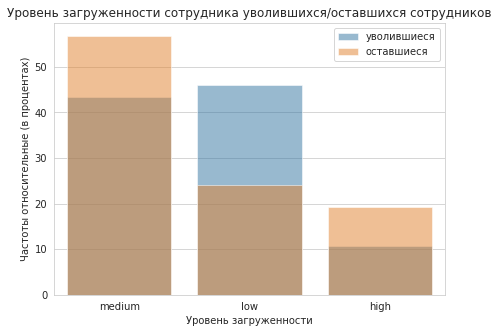

In [125]:
# строим графики для признака 'workload' в разрезе по 'quit'
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")
ax=sns.countplot(data=train_quit_sample.query('quit=="yes"'), x='workload', stat='percent',
                 alpha=0.5)
sns.countplot(data=train_quit_sample.query('quit=="no"'), x='workload', stat='percent',
              alpha=0.5, ax=ax)
plt.ylabel('Частоты относительные (в процентах)')
plt.xlabel('Уровень загруженности')
plt.title('Уровень загруженности сотрудника уволившихся/оставшихся сотрудников')
plt.legend(['уволившиеся', 'оставшиеся'])
plt.show()

In [126]:
# относительные частоты значений признака 'last_year_promo' для уволившихся сотрудников
train_quit_sample.query('quit=="yes"')['last_year_promo'].value_counts(normalize=True)

last_year_promo
no     0.999113
yes    0.000887
Name: proportion, dtype: float64

In [127]:
# относительные частоты значений признака 'dept' для неуволившихся сотрудников
train_quit_sample.query('quit=="no"')['last_year_promo'].value_counts(normalize=True)

last_year_promo
no     0.961003
yes    0.038997
Name: proportion, dtype: float64

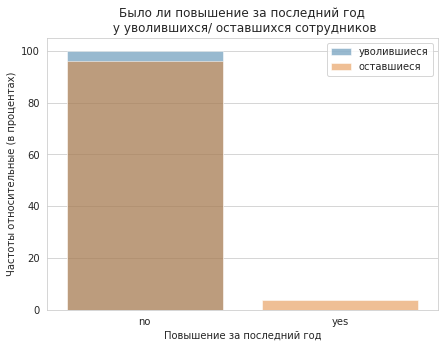

In [128]:
# строим графики для признака 'last_year_promo' в разрезе по 'quit'
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")
ax=sns.countplot(data=train_quit_sample.query('quit=="yes"'), x='last_year_promo', stat='percent',
                 alpha=0.5)
sns.countplot(data=train_quit_sample.query('quit=="no"'), x='last_year_promo', stat='percent',
              alpha=0.5, ax=ax)
plt.ylabel('Частоты относительные (в процентах)')
plt.xlabel('Повышение за последний год')
plt.title('Было ли повышение за последний год\n у уволившихся/ оставшихся сотрудников')
plt.legend(['уволившиеся', 'оставшиеся'])
plt.show()

In [129]:
# относительные частоты значений признака 'last_year_violations' для уволившихся сотрудников
train_quit_sample.query('quit=="yes"')['last_year_violations'].value_counts(normalize=True)

last_year_violations
no     0.797872
yes    0.202128
Name: proportion, dtype: float64

In [130]:
# относительные частоты значений признака 'last_year_violations' для неуволившихся сотрудников
train_quit_sample.query('quit=="no"')['last_year_violations'].value_counts(normalize=True)

last_year_violations
no     0.889624
yes    0.110376
Name: proportion, dtype: float64

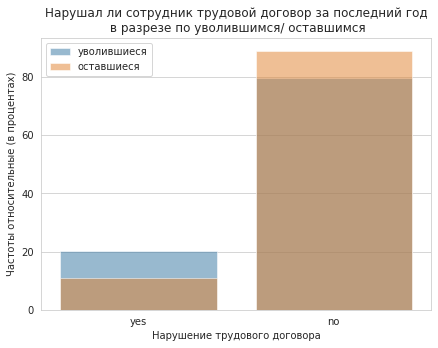

In [131]:
# строим графики для признака 'last_year_violations' в разрезе по 'quit'
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")
ax=sns.countplot(data=train_quit_sample.query('quit=="yes"'), x='last_year_violations', stat='percent',
                 alpha=0.5)
sns.countplot(data=train_quit_sample.query('quit=="no"'), x='last_year_violations', stat='percent',
              alpha=0.5, ax=ax)
plt.ylabel('Частоты относительные (в процентах)')
plt.xlabel('Нарушение трудового договора')
plt.title('Нарушал ли сотрудник трудовой договор за последний год\n в разрезе по уволившимся/ оставшимся')
plt.legend(['уволившиеся', 'оставшиеся'])
plt.show()

In [132]:
# относительные частоты значений признака 'supervisor_evaluation' для уволившихся сотрудников
train_quit_sample.query('quit=="yes"')['supervisor_evaluation'].value_counts(normalize=True)

supervisor_evaluation
3    0.463652
4    0.253546
2    0.145390
1    0.084220
5    0.053191
Name: proportion, dtype: float64

In [133]:
# относительные частоты значений признака 'supervisor_evaluation' для неуволившихся сотрудников
train_quit_sample.query('quit=="no"')['supervisor_evaluation'].value_counts(normalize=True)

supervisor_evaluation
4    0.476323
3    0.247214
5    0.160167
2    0.079039
1    0.037256
Name: proportion, dtype: float64

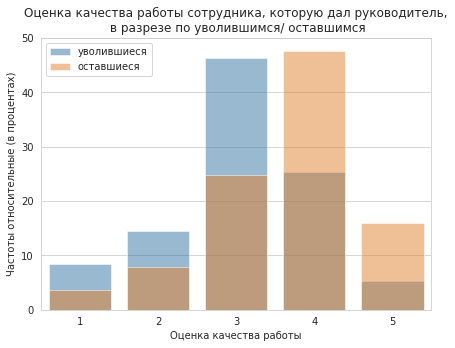

In [134]:
# строим графики для признака 'supervisor_evaluation' в разрезе по 'quit'
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")
ax=sns.countplot(data=train_quit_sample.query('quit=="yes"'), x='supervisor_evaluation', stat='percent',
                 alpha=0.5)
sns.countplot(data=train_quit_sample.query('quit=="no"'), x='supervisor_evaluation', stat='percent',
              alpha=0.5, ax=ax)
plt.ylabel('Частоты относительные (в процентах)')
plt.xlabel('Оценка качества работы')
plt.title('Оценка качества работы сотрудника, которую дал руководитель,\n в разрезе по уволившимся/ оставшимся')
plt.legend(['уволившиеся', 'оставшиеся'])
plt.show()

<div class="alert alert-success">
    
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Проанализирован портрет уволившегося сотрудника.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> 
    
1. Анализ категориальных/дискретных признаков нужно сделать с помощью относительных величин - оперировать абсолютными величинами не всегда удобно, так как в зависимости от масштаба исследования (компания на 100 человек и компания на 100 000 человек, например) результаты могут быть более или менее интерпретируемыми. Для категориальных/дискретных признаков мы можем использовать `value_counts(normalize=True)`, для непрерывных можно посчитать и сравнить средние.
    
2. При этом обрати внимание, что относительные величины нужно считать именно по срезу `quit='yes'`, а не делать анализ в разрезе `quit`: в случае, если у нас будет сильный дисбаланс целевого признака (например, 99/1), текущий формат анализа будет неинформативен, так как все доли оттока будут в где-то на дне графика.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Ввёл относительную величину для категориальных/ дискретных признаков и медиану для количественных. А вот по п.2 невполне понял замечание. Ведь если использовать только срез `quit='yes'`, то никакого сравнения уволившихся с работающими сотрудниками не получится, разве нет? А хочется именно сравнить две категории, так получается более информативный портрет уволившегося сотрудника. Разъясни, пожалуйста, если не так понял.
    
Я в результате ввёл относительные (процентные) частоты и добавил два графика на одну шкалу - для `quit='yes'` и `quit='no'`. Думаю, при сильном дисбалансе, тоже будет хорошо отображаться, т.к. процентные частоты же отдельно по каждому графику выводятся.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Можно и так, да.

In [135]:
# добавлем в тестовую выборку значения признака 'job_satisfaction_rate'
test_features = test_features.merge(test_sample[['id', 'job_satisfaction_rate']], on='id')

In [136]:
# описательная статистика по признаку 'job_satisfaction_rate' для уволившихся сотрудников
test_features.query('quit=="yes"')['job_satisfaction_rate'].median()

np.float64(0.37)

In [137]:
# описательная статистика по признаку 'job_satisfaction_rate' для уволившихся сотрудников
test_features.query('quit=="no"')['job_satisfaction_rate'].median()

np.float64(0.66)

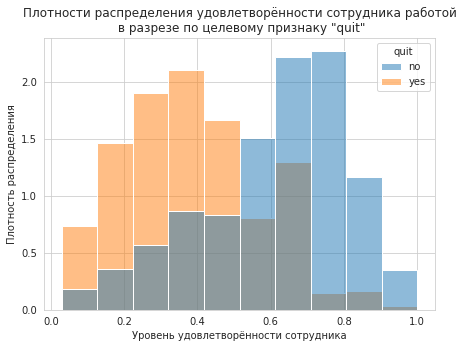

In [138]:
# строим график для признака 'job_satisfaction_rate' по тестовой выборке
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")
sns.histplot(stat='density', common_norm=False, data=test_features, x='job_satisfaction_rate', hue='quit', bins=10)
plt.ylabel('Плотность распределения')
plt.xlabel('Уровень удовлетворённости сотрудника')
plt.title('Плотности распределения удовлетворённости сотрудника работой\n в разрезе по целевому признаку "quit"')
plt.show()

<div class="alert alert-success">
    
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Исследовано распределение удовлетворённости в зависимости от факта ухода.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Чуть более интересным решением, позволяющим выполнить оценку не "на глаз", а более статистически достоверно, было бы использование статистического теста (например, `ttest`) для сравнения распределений в выборках. 
        
При этом не забывай, что при проведении статистических тестов обязательно нужно формулировать гипотезы - нулевую и альтернативную.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Спасибо за рекомендацию! Согласен, что оценки на глаз по графика не хватает статистической точности. Но мне нравится визуализация, думаю оба способа можно использовать и комплексно.
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Да, вполне можно.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Аналогично нужна нормированная гистограмма.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Исправил.
</div>

<div class="alert alert-success">
    
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

In [139]:
phik_overview = phik_matrix(test_features.drop('id', axis=1), interval_cols = interval_cols)

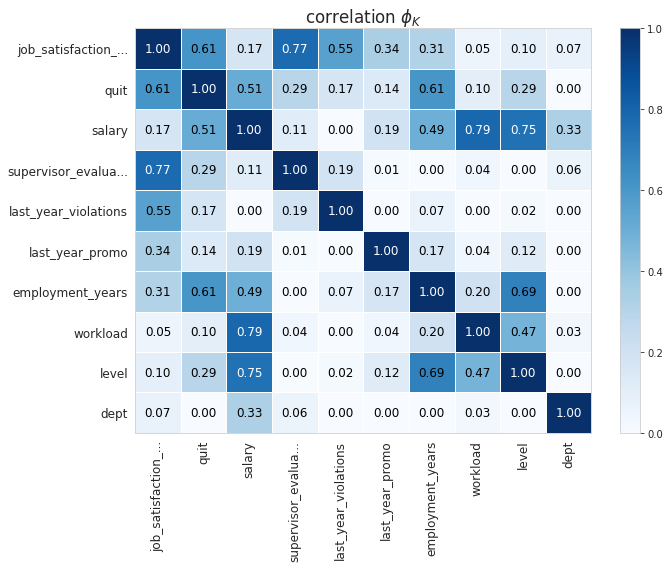

In [140]:
# визуализируем корреляции между всеми признаками датафрейма test_features
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns,
                        y_labels=phik_overview.index, vmin=0, vmax=1, color_map='Blues',
                        title='correlation $\phi_K$', fontsize_factor=1.2, figsize=(10, 8))

**Выводы:**

Мы изучили описательную статистику и вывели графики для всех признаков по новой тренировочной выборке (тестовая выборка та же, что в первой задаче). Для количественных непрерывных признаков мы вывели диаграммы размаха и гистограммы частотного распределения, для дискретных количественных признаков - диаграммы типа `countplot`, а для категориальных признаков вывели круговые диаграммы. Новая тренировочная выборка имеет распределения значений входных признаков схожие с тренировочной выборкой из первой задачи. 

Мы объединили входные и целевой признак тестовой выборки в один датафрейм, затем посмотрели распределение значений целевого признака по тренировочной и тестовой выборкам. Распредедление целевого признака по тренировочной и тестовой выборкам в относительном выражении имеют незначительные расхождения. По тренировочной выборке доля уволившихся сотрудников составляет 25,3%, а оставшихся 74,7%. Мы видим, что распределение значений целевого признака имеет дисбаланс.

Затем мы по тренировочной выборке на основе графиков изучили распределение всех признаков в разрезе по целевому признаку `'quit'` — увольнение сотрудника из компании, чтобы изучить, какие есть зависимости между значениями входных и целевого признаков, и таким образом составить портрет «уволившегося сотрудника». Т.к. в нашей задаче есть явный дисбалас классов, мы вывели нормализованные гистограммы для количественных признаков, сравнив плотности распределения значений по целевому признаку. Для категориальных и дискретных количественных признаков мы посчитали относительные частоты значений, а количественные признаки сравнили по медианному значению в разрезе по целевому признаку.

Мы видим, что есть определенная зависимость между длительностью работы сотрудника и увольнением. Так, медианное значение длительности работы для уволившихся сотрудников — 1 год работы, тогда как сотрудники, проработавшие 5 лет и выше увольняются сравнительно редко. 1 год также является наиболее частотой длительностью работы уволившегося сотрудника. Графики и статистика зарплат также показывают зависимость между уровнем зарплат и увольнением. Медианное значение зарплаты для уволившихся сотрудников (по тестовой выборке) — 22800. А медианное значение зарплаты для неуволившихся сотрудников — 34800. Уволившиеся сотрудники в относительном выражении гораздо реже чем неуволившиеся сотрудники получают зарплату выше 30000, и совсем редко выше 40000, тогда как как среди неуволившихся сотрудников такая зарплата встречается часто. В то же время уволившиеся сотрудники но гораздо чаще чем неуволившиеся получают зарплату менее 25000.

Графики показывают, что отдел не оказывает никакого влияния на увольнение сотрудника, доли уволившихся сотрудников в каждом отделе отличаются незначительно, заметной связи отдела с целевым признаком не наблюдается. Зато есть явная зависимость между уровнем занимаемой должности и увольнением: подавляющее число (89%) уволившихся сотрудников занимали должность увовня junior. У оставшихся сотрудников самый популярный уровень занимаемой должности middle - 52%, а уровень junior у 33% работающих сотрудников.

Наибольшая доля уволившихся сотрудников приходится на сотрудников с низкой загруженностью на работе (46%), а доля уволившихся сотрудников с высокой загруженностью сравнительно небольшая (10.7%). Среди уволившихся менее 1% сотрудников получили повышение за последний год, тогда как среди оставшихся - почти 4%. Среди уволившихся сотрудников доля сотрудников, нарушивших договор за последний год, составляет 20%, тогда как среди оставшихся - 11%. Медианное и модальное значение полученной оценки качества работы у уволившихся сотрудников составляет 3, тогда как для неуволившихся медианное и модальное значение оценки приходится на 4. Среди уволившихся сотрудников лишь 30% получили оценку выше 3.

Мы также сравнили по тестовой выборке уровень удовлетворенности работой (взяли из первой задачи) с увольнениями по данным для второй задачи. Статиска показывает, что медианное значение удовлетворенности работой среди уволившихся сотрудников составляет 0.37, тогда как среди оставшихся работать сотрудников — 0.66, т.е. почти в 2 раза выше. На графике видно, что уровень удовлетворенности ниже 0.5 заметно чаще встречается у уволившихся сотрудников, тогда как выше 0.5 гораздо чаще получают оставшиеся. Среди сотрудников с уровнем удовлетворенности выше 0.7 доля уволившихся очень незначительная (приближается к 0). 

Матрица корреляции между всеми признаками (за исключением признака id) со значениями коэффициентов корреляции Фи(Phi) показала заметную связь целевого признака `quit` (увольнения) с признаками: `'job_satisfaction_rate'` (удовлетворенность работой) — коэффициент корреляции 0.61, `'employment_years'` (длительность работы) — коэффициент корреляции 0.61, и `'salary'` (зарплата) — коэффициент корреляции 0.51. Значение корреляции Фи(Phi) между целевым признаком и признаком `'dept'` (отдел) равно 0. Для построения модели прогнозирования увольнения стоит исключить входной признак `'dept'`.

### Добавление нового входного признака 

In [141]:
# получаем предсказания 'job_satisfaction_rate' по лучшей модели из первой задачи  для тренировочной выборки из второй задачи 
y_pred_train = pd.DataFrame(rs.predict(train_quit_sample.drop(['id', 'quit'], axis=1)), columns = ['job_satisfaction_rate_pred'])
# создаём датафрейм с 'id' и предсказанными значениями 'job_satisfaction_rate'
y_pred_train.head()

,job_satisfaction_rate_pred
0,0.554278
1,0.859775
2,0.312572
3,0.280098
4,0.737619


In [142]:
# добавляем новый входной признак в датафрейм тренировочной выборки для второй задачи
train_quit_sample['job_satisfaction_rate_pred'] = y_pred_train
# выводим первые строки получившегося датафрейма
train_quit_sample.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
0,723290,sales,middle,high,2,no,no,4,54000,no,0.554278
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.859775
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.312572
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.280098
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.737619


In [143]:
# преобразуем предсказанные лучшей моделью значения 'job_satisfaction_rate' для тестовой выборки в датафрейм (столбец)
y_pred_test = pd.DataFrame(y_pred, columns = ['job_satisfaction_rate_pred'])

In [144]:
# убираем добавленный ранее столбец 'job_satisfaction_rate' из тестовой выборки
test_features = test_features.drop('job_satisfaction_rate', axis=1)
# добавляем новый входной признак в датафрейм тестовой выборки для второй задачи
test_features = pd.concat([test_features, y_pred_test], axis=1)
# выводим первые строки получившегося датафрейма
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
0,485046,marketing,junior,medium,2,no,no,5,28800,no,0.799726
1,686555,hr,junior,medium,1,no,no,4,30000,no,0.685002
2,467458,sales,middle,low,5,no,no,4,19200,no,0.620079
3,418655,sales,middle,low,6,no,no,4,19200,no,0.681936
4,789145,hr,middle,medium,5,no,no,5,40800,no,0.770099


<div class="alert alert-success">
    
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> В выборки добавлен новый признак на основе предсказаний модели из предыдущей задачи.

### Подготовка данных 

In [145]:
# проверим наличие явных дубликатов в данных тренировочной выборки, используемых для моделирования
train_quit_sample.drop('id', axis=1).duplicated().sum()

np.int64(1413)

In [146]:
# видим, что после удаления 'id' в выборке есть дубликаты, удаляем их, т.к. дубли не имеют ценности для модели
train_quit_sample = train_quit_sample.drop('id', axis=1).drop_duplicates().reset_index(drop=True)

In [147]:
# задаем входные и целевые признаки для тренировочной и тестовой выборок
X_train = train_quit_sample.drop(['quit', 'dept'], axis=1)
y_train = train_quit_sample['quit']
X_test = test_features.drop(['quit', 'id', 'dept'], axis=1)
y_test = test_features['quit']

In [152]:
# кодируем целевой признак
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train_le = label_encoder.transform(y_train)
y_test_le = label_encoder.transform(y_test)

In [154]:
# посмотрим, как кодировался признак
# 'yes' (т.е. сотрудник уволился) кодируется значением 1, а 'no' (т.е. сотрудник не уволился) значением 0
display('Значения целевого признака до кодирования', y_test.head(10))
display('Значения целевого признака после кодирования', pd.DataFrame(y_test_le, columns=['quit_le']).head(10))

'Значения целевого признака до кодирования'

0     no
1     no
2     no
3     no
4     no
5    yes
6    yes
7     no
8     no
9    yes
Name: quit, dtype: object

'Значения целевого признака после кодирования'

,quit_le
0,0
1,0
2,0
3,0
4,0
5,1
6,1
7,0
8,0
9,1


<div class="alert alert-success">
    
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Молодец, что используешь `LabelEncoder` для кодирования целевого признака.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Обучать кодировщик нужно на `y_train`.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Исправил. Алексей, у меня остался вопрос, можно ли как-то настроить LabelEncoder? Т.е. он обычно кодирует значения в лексикографическом порядке. А что если мы хотим, чтобы конкретное значение целевого признака (до кодирования) кодировалось конкретным образом, т.е. например хотим кодировать положительный класс 1, тогда как при лексикографическом кодировании мы получаем другое значение. Можно ли так сделать?
</div>

<div class="alert alert-success">
    
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено. Можно явно задать порядок классов при использовании `LabelEncoder`:
    
    le = LabelEncoder()
    le.fit(y_train)
    
    le.classes_ -> array(['yes', 'no'] - соответствует yes=0 и no=1, диаметрально тому, что нам нужно
    
    le.classes_ = np.array(['no', 'yes'])
    
    le.classes_ -> array(['no', 'yes'] - соответствует no=0 и yes=1, именно так нам и нужно

In [155]:
# задаем категориальные признаки для разных типов кодтирования и количественные признаки 
ohe_columns = ['last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate_pred']

Для кодирования и масштабирования признаков мы будем использовать те же пайплайны, что мы создали для решения первой задачи: `ohe_pipe`, `ord_pipe` и `num_pipe`.

In [156]:
# создаем пайплайн для обработки данных
data_preprocessor_2 = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

In [157]:
# выведем датафреймы с преобразованными входными признаками после кодирования и масштабирования
X_train_pre = pd.DataFrame(
    data_preprocessor_2.fit_transform(X_train),
    columns=data_preprocessor_2.get_feature_names_out()
)

X_test_pre = pd.DataFrame(
   data_preprocessor_2.transform(X_test),
   columns=data_preprocessor_2.get_feature_names_out()
)

display(X_train_pre.head())
X_test_pre.head()

,ohe__last_year_promo_yes,ohe__last_year_violations_yes,ord__level,ord__workload,num__employment_years,num__supervisor_evaluation,num__salary,num__job_satisfaction_rate_pred
0,0.0,0.0,1.0,2.0,-0.851101,0.585172,1.038618,0.164211
1,0.0,0.0,0.0,1.0,-0.851101,0.585172,-0.584578,1.595381
2,0.0,0.0,1.0,1.0,0.302478,-2.192517,0.005676,-0.968116
3,0.0,1.0,0.0,1.0,-0.851101,-0.340724,-0.805922,-1.120251
4,0.0,0.0,0.0,1.0,-0.851101,1.511068,-0.732141,1.023113


,ohe__last_year_promo_yes,ohe__last_year_violations_yes,ord__level,ord__workload,num__employment_years,num__supervisor_evaluation,num__salary,num__job_satisfaction_rate_pred
0,0.0,0.0,0.0,1.0,-0.851101,1.511068,-0.510796,1.314066
1,0.0,0.0,0.0,1.0,-1.235627,0.585172,-0.437014,0.776615
2,0.0,0.0,1.0,0.0,0.302478,0.585172,-1.101049,0.472467
3,0.0,0.0,1.0,0.0,0.687005,0.585172,-1.101049,0.762251
4,0.0,0.0,1.0,1.0,0.302478,1.511068,0.227020,1.175274


**Выводы:**

После удаления из признаков, используемых в моделировании, признака 'id' мы провели проверку на наличие явных дубликатов по оставшимся данным в тренировочной выборке. Мы обнаружили 1413 дублей и удалили их, т.к. они не представляют ценности для моделирования.

Предварительно мы задали целевой и входной признак для тренировочной и тестовой выборкам. Из входных признаков мы исключили признаки 'id' и 'dept'. Затем мы обработали целевой признак с помощью кодировщика LabelEncoder(), знаачения 'yes' кодировались значением 1, а значения 'no' кодировались значением 0. Для подготовки данных по второй задаче мы использовали те же пайплайны кодирования и масштабирования, что создали ранее для решения первой задачи. Признаки для кодирования для второй задачи отличаются с учётом добавленного нового входного признака - предсказанные значения 'job_satisfaction_rate' по лучшей моделе, найденной в первой задаче. Мы создали пайплайн для обработки данных и преобразования столбцов с помощью ColumnTransform и включили в него три созданных ранее пайплайна для кодирования и масштабирования данных. Затем чтобы посмотреть выполнение этапа подготовки данных, мы сформировали датафреймы из преобразованных данных для тренировочной и тестовой выборок и вывели первые строки датафреймов на экран.

### Обучение моделей

In [158]:
# создаём итоговый пайплайн с подготовкой дапнных и моделью
pipe_final_2 = Pipeline(
    [
        ('preprocessor', data_preprocessor_2),
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

In [161]:
# задаем словари гиперпараметров для трёх моделей  
param_rs_2 = [
    # для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, penalty='l1',
                                   solver='liblinear')],
        'models__C': range(1, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
     # для модели SVC()              
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True, kernel='rbf')],
        'models__C': range(1, 5),
        'models__gamma': [0.03, 0.05, 0.1, 0.3, 1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },

    # для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': [5, 7, 9, 12],
        'models__metric': ['euclidean', 'cityblock'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }

             ]

In [162]:
# находим лучшую модель на данных кросс-валидационной выборки
rs_2 = RandomizedSearchCV(pipe_final_2, param_distributions=param_rs_2, cv=5, scoring='roc_auc',
                        n_iter=20, n_jobs=-1, verbose=3, random_state=RANDOM_STATE)
rs_2.fit(X_train, y_train_le)
# выводим параметры лучшей модели
print('Лучшая модель и её параметры:\n\n', rs_2.best_estimator_,'\n\n', rs_2.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END models=SVC(probability=True, random_state=42), models__C=4, models__gamma=0.1, preprocessor__num=StandardScaler();, score=0.909 total time=   0.3s
[CV 2/5] END models=SVC(probability=True, random_state=42), models__C=4, models__gamma=0.1, preprocessor__num=StandardScaler();, score=0.892 total time=   0.3s
[CV 3/5] END models=SVC(probability=True, random_state=42), models__C=4, models__gamma=0.1, preprocessor__num=StandardScaler();, score=0.900 total time=   0.3s
[CV 4/5] END models=SVC(probability=True, random_state=42), models__C=4, models__gamma=0.1, preprocessor__num=StandardScaler();, score=0.883 total time=   0.3s
[CV 5/5] END models=SVC(probability=True, random_state=42), models__C=4, models__gamma=0.1, preprocessor__num=StandardScaler();, score=0.916 total time=   0.4s
[CV 1/5] END models=SVC(probability=True, random_state=42), models__C=1, models__gamma=0.1, preprocessor__num=StandardScaler();, score=0.9

In [163]:
# считаем и выводим для лучшей модели метрику roc_auc_score
print('Значение метрики ROC_AUC для лучшей модели:', round(rs_2.best_score_, 3))
# по лучшей модели делаем прогноз на тестовой выборке
y_proba = rs_2.predict_proba(X_test)[:,1]
# считаем и выводим для лучшей модели метрику smape на тестовой выборке
roc_auc_test = roc_auc_score(y_test_le, y_proba)
print('Значение метрики ROC_AUC для лучшей модели на тестовой выборке:', round(roc_auc_test, 3))

Значение метрики ROC_AUC для лучшей модели: 0.909
Значение метрики ROC_AUC для лучшей модели на тестовой выборке: 0.922


In [164]:
# проверим лучшую модель на адекватность, сравнив качество её предсказаний с качеством предсказаний модели DummyRegressor(strategy="median")
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train, y_train_le)
y_pred_dummy = dummy_model.predict_proba(X_test)[:,1]
score_test_dummy = roc_auc_score(y_test, y_pred_dummy)
print('Значение метрики ROC_AUC для модели DummyClassifier на тестовой выборке:', round(score_test_dummy, 3))

Значение метрики ROC_AUC для модели DummyClassifier на тестовой выборке: 0.5


Мы видим, что у лучшей модели значение метрики ROC_AUC на тестовой выборке заметно лучше, чем у модели DummyClassifier. Значит лучшая модель адекватная.

<div class="alert alert-success">
    
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Лучшую модель оценили на `test` - отличный результат!

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Аналогично стоит выполнить оценку модели на адеватность - в случае задачи классификации мы можем использовать  `DummyClassifier` (https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier).
        

<div class="alert alert-success">
    
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

### Выводы 

Мы создали итоговый пайплайн для решения задачи, в который включили пайплайн подготовки данных и обработку моделью. Затем мы задали словари с гиперпараметрами для трёх моделей классификации: KNeighborsClassifier(), LogisticRegression() и SVC(). Для каждой модели мы задали гиперпараметры. Для модели LogisticRegression() мы задали l1-регуляризацию, которая сокращает веса незначимых признаков вплоть до нуля, и подбор значения параметра силы регуляризации C - значения от 1 до 6 включительно. Для модели KNeighborsClassifier() мы задали подбор оптимального кол-ва ближайших соседей для классификации среди значений 5, 7, 9, 12, а также на выбор две опции рассчёта расстояния между объектами - 'euclidean' и 'cityblock'. Для модели SVC мы задали в качестве оптимального типа ядра для модели 'rbf', и подбор оптимальных коэффициентов силы регуляризации C - значения от 1 до 4 включительно, и gamma - значения 0.03, 0.05, 0.1, 0.3, 1. Кроме того, для всех трёх моделей мы установили подбор оптимального метода масштабирования/ нормализации количественных признаков - StandardScaler() и MinMaxScaler().

В заключении мы запустили оптимизацию гиперпараметров с помощью селектора RandomizedSearchCV, в который включили заданный словарь гиперпараметров. Мы зафиксировали тип кросс-валидации (задали значение 5), значение random_state и метрику для оценки качества обученных моделей - `'roc-auc'`. Эта метрика отлично подходит для решения задачи бинарной классификации, кроме того она учитывает работу модели при всех возможных значениях порогов для классификации и поэтому не зависит от одного конкретного. Таким образом, мы использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров. 

После применения поиска лучшей модели мы обучили её на тренировочной выборке и затем вывели ёё параметры. Выведенная информация по всем моделям, задействованным в поиске, показывает, что все модели показывают сравнительно неплохие результаты. При определенных значениях гиперпараметров значение метрики ROC_AUC по трём рассмотренным моделям близко к 0.9 или выше. В результате мы получили, что лучшая модель для решения задачи классификации пользователей по покупательской активности - модель "k-ближайших соседей" KNeighborsClassifier() с параметрами:  metric='euclidean' (опция рассчёта расстояния между объектами), n_neighbors=12 (оптимальное кол-во ближайших соседей для классификации) и масштабированием StandardScaler(). Значение метрики ROC_AUC для лучшей модели, полученной на кросс-валидационной выборке - 0.909, на тестовой выборке - 0.922. Таким образом, значение метрики ROC_AUC на тестовой выборке ≥ 0.91, что можно считать критерием успеха. Модель KNeighborsClassifier обладает хорошей адаптацией к данным благодаря возможности подбора метрики для измерения расстояний между точками, не чувствительна к выбросам и отлично подходит для задач с нелинейной зависимостью между целевым и выборочными признаками.

Мы проверили получившуюся лучшую модель на адекватность, сравнив качество её предсказаний с качеством предсказаний модели DummyClassifier с настройкой вывода наиболее частых значений целевого признака в качестве предсказаний. Мы видим, что у лучшей модели значение метрики ROC_AUC на тестовой выборке заметно лучше, чем у модели DummyClassifier. Значит наша лучшая модель адекватная.

## Общий вывод 

В проекте мы решили две поставленные задачи для бизнеса. В первой задаче мы построили модель, которая предсказывает уровень удовлетворённости сотрудника на основе данных заказчика. Во второй задаче мы построили модель, которая на основе данных заказчика предсказывает то, что сотрудник уволится из компании.

Структуры выполнения каждой из двух задач практически одинаковы и имеют незначительные отличия. Сраузу после выгрузки данных мы посмотрели общую информацию по всем столбцам в датафреймах и провели предобработку данных. Мы обработали пропуски в категориальных данных с помощью пайплайна, в котором иcпользовали для выявления и заполнения пропусков класс `SimpleImputer`. Пропущенные значения мы меняли на наиболее часто встречающиеся значения в столбце (`most_frequent`). После устранения пропусков мы убедились, что тип данных по каждому столбцу задан верно, а затем провели проверку на наличие явных и неявных дубликатов данных. 

На следующем этапе мы провели исследовательский анализ данных. Мы изучили описательную статистику и вывели графики для всех признаков отдельно по тренировочной и тестовой выборкам. Для количественных признаков мы вывели диаграммы размаха и гистограммы частотного распределения, для дискретных количественных признаков - диаграммы типа countplot, а для категориальных признаков вывели круговые диаграммы. Мы убедились, что тренировочная и тестовая выборки не имеют заметных расхождений в распределении значений целевого и входных признаков. Выявили, что в данных есть незначительные выбросы по зарплате и что количесвтенные непрерывные признаки имеют распределение, отличное от нормального. При решении второй задачи мы анализировали частотное распределение признаков в разрезе по уволившимся и оставшимся сотрудникам (по целевому признаку `quit`) и в результате получили портрет уволившегося сотрудника. Уволившийся сотрудник в среднем работает не более года в компании и, занимает должность уровня уровня junior, сравнительно часто имеет невысокую загруженность и получает зарплату 22800, что примерно в 1,5 раза ниже зарплаты сотрудников, которые не уволились. Кроме того уволившийся сотрудник почти в 2 раза чаще оставшихся сотрудников нарушает трудовой договор. Средняя и наиболее частая оценка, полученная за работу уволившимся сотрудником 3, тогда как у неуволившихся сотрудников средняя оценка за работу 4. Уровень удовлетворенности работой у уволившегося сотрудника почти в 2 раза ниже, чем у оставшихся сотрудников: 0.37 против 0.66. Данные также показывают, что уволившийся сотрудник примерно с одинаковой вероятностью может работать в любом отделе.

На этапе исследовательского анализа мы вывели матрицу корреляции между всеми признаками (за исключением признака id) со значениями коэффициентов корреляции Фи(Phi). В первой задаче по матрице мы видим, что целевой признак `'job_satisfaction_rate'` (уровень удовлетворенности сотрудника работой) имеет высокую корреляцию с признаком `'supervisor_evaluation'` (оценка качества работы сотрудника) - коэффициент корреляции 0.76, а также заметную корреляцию с признаком `'last_year_violations'` (нарушение трудового договора за последний год) - коэффициент корреляции 0.56. Во второй задаче матрица показала наличие заметной корреляционной связи целевого признака `'quit'` (увольнения) с признаками: `'job_satisfaction_rate'` (удовлетворенность работой) — коэффициент корреляции 0.61, `'employment_years'` (длительность работы) — коэффициент корреляции 0.61, и `'salary'` (зарплата) — коэффициент корреляции 0.51. Значение корреляции Фи(Phi) между целевым признаком и признаком `'dept'` (отдел) равно 0. Для построения оптимальной модели прогнозирования увольнения мы исключили входной признак `'dept'`. Во второй задаче на основании исследовательского анализа мы также решили добавить к входным признакам предсказанные лучшей моделью по первой задаче значения `'job_satisfaction_rate'`.

Следующий этап для обоих задач - подготовка данных. На этом этапе мы отобрали входные и целевой признак для тренировочной и тестовой выборок. Мы выделили категориальные признаки для кодирования методом OneHotEncoder и кодирования методом OrdinalEncoder, а также количественные признаки для масштабирования или нормализации. Кроме того, при решении второй задачи мы кодировали целевой признак с помощью кодировщика LabelEncoder(). С помощью OrdinalEncoder мы решили кодировать признаки, которые можно поместить на шкалу в порядке возрастания, т.е. ранжировать - `'level'` и `'workload'`. Мы создали отдельные пайплайны для кодирования с помощью OneHotEncoder, кодирования с помощью OrdinalEncoder, масштабирования с помощью StandardScaler. В каждый из указанных пайплайнов для обработки данных мы добавили обработку пропусков с помощью класса SimpleImputer. В кодировщик OrdinalEncoder мы добавили упорядоченные списки категорий для признаков `'level'` и `'workload'`. Затем мы создали пайплайн для обработки данных и преобразования столбцов с помощью ColumnTransform. Мы включили в этот пайплайн три созданных ранее пайплайна для кодирования и масштабирования данных. Чтобы посмотреть выполнение этапа подготовки данных, мы сформировали датафреймы из преобразованных данных для тренировочной и тестовой выборок и вывели первые строки датафреймов на экран.

На заключительном этапе мы провели обучение модели и выбрали лучшую модель для решения поставленной задачи на основе выбранной метрики качества модели. В первой задаче мы решали по сути задачу выбор регрессионной модели для предсказания значений уровня удовлетворенности, а во второй - задачу бинарной классификации. Мы создали итоговый пайплайн для решения задачи, в который включили пайплайн подготовки данных и обработку моделью. Затем мы задали словари с гиперпараметрами для трёх моделей. Для первой задачи мы выбрали для поиска оптимальной модели линейные модели LinearRegression() и SVR(), а также модель DecisionTreeRegressor(). Для второй задачи мы отобрали для поиска модели LogisticRegression(), КNN(), SVC(). 

Результаты подбора лучшей модели по параметрам при решении первой задачи показали, что хуже всего справляется с прогнозом целевого признака модель LinearRegression(). По сравнению с LinearRegression() модель DecisionTreeRegressor(random_state=42) при определенных значениях минимального числа объектов в листе/ в узле даёт гораздо лучшие значения метрики SMAPE на кросс-валидационной выборке. И всё-таки в качестве лучшей модели для прогноза целевого признака была выбрана модель SVR() c коэффициентами регуляризации C=4 и gamma=0.3, оптимальным ядром 'rbf' и масштабированием количественных признаков с помощью StandardScaler(). Значение метрики SMAPE для лучшей модели 14.755, а значение SMAPE для лучшей модели на тестовой выборке 13.435. Таким образом, SMAPE ≤ 15, что можно считать критерием успеха. Модель SVR показала лучший результат, поскольку способна улавливать сложные нелинейные зависимости между признаками благодаря настройке ядра, устойчива к переобучению (в отличие от модели типа "дерево решений") благодаря использованию коэффициентов силы регуляризации, устойчива к выбросам и в целом обладает отличными обобщающими способностями.

Результаты подбора лучшей модели по параметрам при решении второй задачи показали, что лучшая модель для решения задачи классификации пользователей по покупательской активности - модель "k-ближайших соседей" KNeighborsClassifier() с параметрами:  metric='euclidean' (опция рассчёта расстояния между объектами), n_neighbors=12 (оптимальное кол-во ближайших соседей для классификации) и масштабированием StandardScaler(). Значение метрики ROC_AUC для лучшей модели, полученной на кросс-валидационной выборке - 0.909, на тестовой выборке - 0.922. Таким образом, значение метрики ROC_AUC на тестовой выборке ≥ 0.91, что можно считать критерием успеха. Модель KNeighborsClassifier обладает хорошей адаптацией к данным благодаря возможности подбора метрики для измерения расстояний между точками, не чувствительна к выбросам и отлично подходит для задач с нелинейной зависимостью между целевым и выборочными признаками.

На основе проделанной работы мы увидели, что основная проблема компании в удержании новых сотрудников, которые приходят на младшие позиции и получают сравнительно низкую зарплату и сравнительно ниже загружены по сравнению с работниками, которые продолжают работать в компании. Мы хотим дать следующие рекомендации компании:

- продумать систему мотивации для новых сотрудников, разработать систему бонусов (как финансовых, так и иных) для работников, достигших высоких показателей (KPI);

- оптимизировать систему загруженности сотрудников, чтобы прежде всего снизить долю сотрудников с низкой загруженностью;

- в конечном счёте после опитимизации загруженности работников можно подумать о сокращении кол-ва работников, при одновременном повышении уровня зарплаты для оставшихся сотрудников, в том числе для сотрудников уровня junior, которых нужно стараться удержать на работе;

- разработать и дать новым сотрудников понятную схему роста в зарплате и уровне занимаемой должности в зависимости от выполнения KPI и ответственности при выполнении поставленных задач.



<div class="alert alert-success">
    
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Есть итоговый вывод и рекомендации.

<div style="border:solid Chocolate 2px; padding: 40px">

# Комментарий ревьюера: общий вывод по проекту.

Евгений, проект получился на довольно хорошем уровне - отличная работа над проектом, молодец!

Мне нравится твой аналитический подход к выполнению проекта, ты соблюдаешь структуру работы, выполняешь её последовательно - это очень хорошо! Шаги проекта выполнены по порядку согласно плану проекта, нет смысловых и структурных ям. Важно, что не забываешь про выводы.

Работа с моделями также выполнена отлично: исследовано несколько алгоритмов, проведён подбор гиперпараметров с помощью `RandomizedSearchCV`, выполнена промежуточная оценка моделей на кросс-валидации - молодец! Здорово, что используешь сочетание `ColumnTransformer` и `Pipeline` для соединения разных инструментов в единый модельный объект и настраиваешь бесперебойную работу энкодера в случае появления в данных новых, неизвестных на момент обучения значений признаков - так твоё решение будет более гибким и масштабируемым. 
    
Над проектом ещё стоит поработать - есть рекомендации по дополнению некоторых твоих шагов проекта. Такие рекомендации я отметил жёлтыми комментариями. Будет здорово, если ты учтёшь их - так проект станет структурно и содержательно более совершенным.
    
Также в работе есть критические замечания. К этим замечаниям я оставил пояснительные комментарии красного цвета, в которых перечислил возможные варианты дальнейших действий. Уверен, ты быстро с этим управишься:)
    
Если о том, что нужно сделать в рамках комментариев, будут возникать вопросы - оставь их, пожалуйста, в комментариях, и я отвечу на них во время следующего ревью.
    
Также буду рад ответить на любые твои вопросы по проекту или на какие-либо другие, если они у тебя имеются - оставь их в комментариях, и я постараюсь ответить:)
    
Жду твой проект на повторном ревью. До встречи:)

<div style="border:solid Chocolate 2px; padding: 40px">

# Комментарий ревьюера: итоговый вывод по проекту.

Евгений, все замечания учтены - проект принят!
    
Спасибо за хорошую работу над проектом, желаю успехов в дальнейшем обучении:)